# Network analysis for error-related brain activity and anxiety dimensions

### Imports

In [208]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import mne
import scipy
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

from collections import defaultdict

from copy import deepcopy
import copy

import pygsp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.utils import resample
from sklearn.covariance import GraphicalLassoCV
from sklearn.metrics.pairwise import cosine_similarity

from scipy.stats.stats import pearsonr

from autoreject import AutoReject

from transformers import *

import warnings
warnings.filterwarnings("ignore")

---
## Load data

Loading EEG data and data from rumination questionnaire. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [2]:
# paths TODO
dir_path = os.path.dirname(os.path.abspath(""))

In [3]:
tmin, tmax = -0.1, 0.6  # Start and end of the segments
signal_frequency = 256
random_state = 0

In [4]:
def create_df_data(
    test_participants=False,
    test_epochs=False,
    info_filename=None,
    info="all",
    personal=True,
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(os.path.abspath(""))
    dir_path = os.path.dirname(os.path.abspath(""))
    print(dir_path)
    header_files_glob = os.path.join(dir_path, "data/responses_100_600_sonata/*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    # cut 20% of data for testing
    h_train, h_test = train_test_split(header_files, test_size=0.3, random_state=0)
    
    print(f"train size: {len(h_train)} ; test size: {len(h_test)}")

    if test_participants:
        header_files = h_test
    else:
        header_files = h_train

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*GNG-(\d+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [5]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename, dtype={'Demo_kod': object})
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info, dtype={'Demo_kod': object})
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )      
    epoch_df = pd.DataFrame({"id": [id], "epoch": [participant_epochs]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [6]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    # event_dict = {
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
    #     "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
    #     "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
    #     "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
    #     "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    # }
    
    event_dict = {
        'Stimulus/RE*ex*1_n*1_c_1*R*FB': 10003,
        'Stimulus/RE*ex*1_n*1_c_1*R*FG': 10004,
        'Stimulus/RE*ex*1_n*1_c_2*R': 10005,
        'Stimulus/RE*ex*1_n*2_c_1*R': 10006,
        'Stimulus/RE*ex*2_n*1_c_1*R': 10007,
        'Stimulus/RE*ex*2_n*2_c_1*R*FB': 10008,
        'Stimulus/RE*ex*2_n*2_c_1*R*FG': 10009,
        'Stimulus/RE*ex*2_n*2_c_2*R': 10010,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10003, 10004, 10008, 10009],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10005, 10006, 10007, 10010],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []
    bads = []
    this_reject_by_annotation = False
    
    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
    )
    
    ar = AutoReject(random_state=random_state, n_jobs=10, verbose=0)
    epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)
    
    return epochs_ar

#### Read the data

In [7]:
def change_column_names(data_df):
    columns_dict = {
        "16-Rumination Full Scale": "RRQ",
        "05-DASS-21 Anxiety scale": "DASS-21 Anx",
        "04-STAI Trait SUM": "STAI-T",
        "07-BIS": "BIS",
        "14-Obsessive-Compulsive WASHING": "WASH",
        "14-Obsessive-Compulsive OBSESSING": "OBSESS",
        "14-Obsessive-Compulsive HOARDING": "HOARD",
        "14-Obsessive-Compulsive ORDERING": "ORD",
        "14-Obsessive-Compulsive CHECKING": "CHECK",
        "14-Obsessive-Compulsive NEUTRALIZING": "NEU",
        # "14-Obsessive-Compulsive FULL": "OCI-R",
        "18-Thought Suppression Inventory": "WBSI",
        "28-Intolerance of Uncertainty - Prospective Anxiety": "IUS-P",
        "28-Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I",
        "06-Self-Esteem Scale_SES Rosenberga": "SES",
        "07-BAS Dzialanie": 'BAS_D',
        "07-BAS Poszukiwanie przyjemnosci": 'BAS_PRZY',
        "07-BAS Wrazliwosc na nagrode": 'BAS_NAG',
        "22-Nonforgiveness - Full Scale": 'NONFOR',
        "27-Indecisiveness Scale_Frost": 'INDEC_F',
        "03-SP (Punishment Sensitivity)": 'PUN',
        "03-SR (Reward Sensitivity)": 'REW',
        "15-Obsessional Beliefs - Inflated responsibility for harm": 'HARM',
        "15-Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR',
        "15-Obsessional Beliefs - Overestimation of threat": "OT",
        "15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF',
        "17-Perfectionism CMDA": 'CMDA',
        "17-Perfect PS-Personal Standards (7 items mean)" : 'PS',
        "19-Guilt sensitivity": 'G_SE',
        "31-NFC Nietolerancja wieloznaczności-FULL": 'AMB',
        "31-NFC Preferowanie przewidywalności-FULL": 'PRED',
        "32-High standards from Maximization Full Scale" : 'STAND',   
        "Wiek": "Age",
        "Płeć": "Sex",
        "Ręczność": "Handness",    

        "Rumination Full Scale": "RRQ",
        "DASS-21 Anxiety scale": "DASS-21 Anx",
        "STAI Trait SUM": "STAI-T",
        "BIS": "BIS",
        "Obsessive-Compulsive WASHING": "WASH",
        "Obsessive-Compulsive OBSESSING": "OBSESS",
        "Obsessive-Compulsive HOARDING": "HOARD",
        "Obsessive-Compulsive ORDERING": "ORD",
        "Obsessive-Compulsive CHECKING": "CHECK",
        "Obsessive-Compulsive NEUTRALIZING": "NEU",
        # "14-Obsessive-Compulsive FULL": "OCI-R",
        "Thought Suppression Inventory": "WBSI",
        "Intolerance of Uncertainty - Prospective Anxiety": "IUS-P",
        "Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I",
        "Self-Esteem Scale_SES Rosenberga MEAN": "SES",
        "BAS Dzialanie": 'BAS_D',
        "BAS Poszukiwanie przyjemnosci": 'BAS_PRZY',
        "BAS Wrazliwosc na nagrode": 'BAS_NAG',
        # "22-Nonforgiveness - Full Scale": 'NONFOR',
        "Indecisiveness Scale_Frost": 'INDEC_F',
        "SP (Punishment Sensitivity)": 'PUN',
        "SR (Reward Sensitivity)": 'REW',
        "Obsessional Beliefs - Inflated responsibility for harm": 'HARM',
        "Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR',
        "Obsessional Beliefs - Overestimation of threat": "OT",
        "Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF',
        # "17-Perfectionism CMDA": 'CMDA',
        "Perfect PS-Personal Standards (7 items mean)" : 'PS',
        "Guilt sensitivity": 'G_SE',
        "Nietolerancja wieloznaczności-FULL": 'AMB',
        "Preferowanie przewidywalności-FULL": 'PRED',
        "High standards from Maximization Full Scale" : 'STAND',   
    }

    data_df = data_df.rename(columns=columns_dict)
    return data_df

In [8]:
# %%capture
df_name = "GNG_autoreject_3_5"
# df_name = "GNG_reject_auto_3-5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_opus_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    # save loaded data into a pickle file
    epochs_train_opus_df.to_pickle("../data/" + epochs_train_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [9]:
epochs_train_opus_df.shape

(110, 188)

In [10]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5"
# df_name = "GNG_reject_auto_3-5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_sonata_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    # save loaded data into a pickle file
    epochs_train_sonata_df.to_pickle("../data/" + epochs_train_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [11]:
epochs_train_sonata_df.shape

(150, 105)

In [12]:
epochs_train_sonata_df.loc[epochs_train_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

#### Read data for external testing

In [13]:
# %%capture
df_name = "GNG_autoreject_3_5_test"
pickled_data_filename = "../data/" + df_name + ".pkl"
# info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
# info_filename = "../data/scales/all_scales.csv"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_opus_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    # save loaded data into a pickle file
    epochs_test_opus_df.to_pickle("../data/" + epochs_test_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [14]:
epochs_test_opus_df.shape

(45, 162)

In [15]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5_test"
pickled_data_filename = "../data/" + df_name + ".pkl"
# info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
# info_filename = "../data/scales/all_scales.csv"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_sonata_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    # save loaded data into a pickle file
    epochs_test_sonata_df.to_pickle("../data/" + epochs_test_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [16]:
epochs_test_sonata_df.shape

(67, 105)

In [17]:
epochs_test_sonata_df.loc[epochs_test_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

## Merge dataframes

In [18]:
opus_columns_list = epochs_train_opus_df.columns.to_list()
sonata_columns_list = epochs_train_sonata_df.columns.to_list()

columns = list(set(opus_columns_list) & set(sonata_columns_list))

In [19]:
epochs_train_sonata_df = epochs_train_sonata_df[columns]
epochs_train_opus_df = epochs_train_opus_df[columns]

epochs_test_sonata_df = epochs_test_sonata_df[columns]
epochs_test_opus_df = epochs_test_opus_df[columns]

Create train and test data

In [20]:
epochs_train_df = pd.concat([epochs_train_sonata_df, epochs_train_opus_df], ignore_index=True)
epochs_test_df = pd.concat([epochs_test_sonata_df, epochs_test_opus_df], ignore_index=True)

#### Chose dataset

In [98]:
test = True
dataset = 'test' if test else 'train'

In [99]:
epochs_df = epochs_train_df if not test else epochs_test_df

In [100]:
epochs_df.shape

(112, 34)

## Visualize data

In [101]:
# todo

## Extract features

#### Extract EEG features

In [102]:
class CenteredSignalAfterBaseline_this(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 2

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 5), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmax(epoch[1]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 2, index + 2), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [103]:
class PeakToPeak(TransformerMixin, BaseEstimator):
    def __init__(self, start=-0.1, stop=0.2, zero=0.0):
        super().__init__()
        self.start = start
        self.stop = stop
        self.zero = zero
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        zero_index = int((X.shape[-1]/(abs(self.start) + abs(self.stop))) * (self.zero-self.start))
        print(zero_index)
        
        peak_to_peaks = np.array(
            [
                np.array([[max(component[zero_index:-1]) - min(component[0:zero_index+1])] for component in participant])
                for participant in X
            ]
        )

        print(f"IN ERN min max RETURN SHAPE: {peak_to_peaks.shape}")
        return peak_to_peaks

In [104]:
class PeakToPeakBins(TransformerMixin, BaseEstimator):
    def __init__(self, zero_index=2):
        super().__init__()
        self.zero_index = zero_index # how many bins before zero the signal started
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
                
        peak_to_peaks = np.array(
            [
                np.array([[max(component[self.zero_index:-1]) - min(component[0:self.zero_index+1])] for component in participant])
                for participant in X
            ]
        )

        print(f"IN ERN min max RETURN SHAPE: {peak_to_peaks.shape}")
        return peak_to_peaks

 1. ICA (FastICA)
 
 - ROI
 - time window: -100 to 200 ms
 - ICA(n=4)
 - no binning
 - peak-to-peak amplitude

In [105]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 12
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    # "P1", "Pz", "P2",
]

roi = ["Fpz", "AFz", "F3", "F1", "Fz", "F2", "F4", "FC3", "FC1", "FCz", "FC2", "FC4", "C3", "C1","Cz", "C2", "C4",]

In [106]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    ("spatial_filter",FastICA(n_components=spatial_filter_components, random_state=random_state)),
    ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
    ("lowpass_filter", LowpassFilter()),
    # ("binning", BinTransformer(step=12)),
    # ("centering", CenteredSignalAfterBaseline_this()),
    # ("ern_data_extraction", ErnTransformer(stop_ern_bin=3)), #3 
    ("peak-to-peak", PeakToPeak()),
]).fit(epochs_df_copy)

preprocessed_X_PCA_12bins = pipeline.transform(epochs_df_copy)

preprocessed_X_PCA_12bins = preprocessed_X_PCA_12bins.reshape(preprocessed_X_PCA_12bins.shape[0], -1)

IN PE RETURN SHAPE: (214, 17, 78)
(112, 17, 78)
IN PE RETURN SHAPE: (214, 17, 78)
(112, 17, 78)
25
IN ERN min max RETURN SHAPE: (112, 4, 1)


In [107]:
preprocessed_X_PCA_12bins.shape

(112, 4)

In [108]:
preprocessed_X_PCA_12bins_2 = preprocessed_X_PCA_12bins[:,0:2]
preprocessed_X_PCA_12bins_2.shape

(112, 2)

 2. ICA smaller bins
 
 - ROI
 - time window: -100 to 200 ms
 - ICA(n=4)
 - binning: 24ms (6 tp)
 - peak-to-peak amplitude

In [109]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 6
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    # "P1", "Pz", "P2",
]
roi = ["Fpz", "AFz", "F3", "F1", "Fz", "F2", "F4", "FC3", "FC1", "FCz", "FC2", "FC4", "C3", "C1","Cz", "C2", "C4",]

In [110]:
class CenteredSignalAfterBaseline_this2(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 4

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 10), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmax(epoch[1]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 4, index+2), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [111]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    ("spatial_filter",FastICA(n_components=spatial_filter_components, random_state=random_state)),
    ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=6)),
    # ("centering", CenteredSignalAfterBaseline_this2()),
    # ("ern_data_extraction", ErnTransformer(stop_ern_bin=6)),
    ("peak-to-peak", PeakToPeakBins(5)),
]).fit(epochs_df_copy)

preprocessed_X_PCA_6bins = pipeline.transform(epochs_df_copy)

preprocessed_X_PCA_6bins = preprocessed_X_PCA_6bins.reshape(preprocessed_X_PCA_6bins.shape[0], -1)

IN PE RETURN SHAPE: (214, 17, 78)
(112, 17, 78)
IN PE RETURN SHAPE: (214, 17, 78)
(112, 17, 78)
IN ERN min max RETURN SHAPE: (112, 4, 1)


In [112]:
preprocessed_X_PCA_6bins.shape

(112, 4)

In [113]:
preprocessed_X_PCA_6bins_2 = preprocessed_X_PCA_6bins[:,0:2]
preprocessed_X_PCA_6bins_2.shape

(112, 2)

 3. ERN bins
 
 - ROI
 - time window: -100 to 200 ms
 - binning: 24ms (6 tp)
 - Centering
 - peak-to-peak

In [114]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 6
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

In [115]:
class CenteredSignalAfterBaseline_ern(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 4

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 10), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmin(epoch[3]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 4, index+2), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [116]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=6)),
    ("centering", CenteredSignalAfterBaseline_ern()),
    ("ern_data_extraction", ErnTransformer(start_ern_bin=1, stop_ern_bin=6)),
    ("peak-to-peak", ErnAmplitude2()),
]).fit(epochs_df_copy)

preprocessed_X_ERN_6bins_ptp = pipeline.transform(epochs_df_copy)

preprocessed_X_ERN_6bins_ptp = preprocessed_X_ERN_6bins_ptp.reshape(preprocessed_X_ERN_6bins_ptp.shape[0], -1)

IN PE RETURN SHAPE: (214, 13, 78)
(112, 13, 78)
IN PE RETURN SHAPE: (214, 13, 78)
(112, 13, 78)


In [117]:
preprocessed_X_ERN_6bins_ptp.shape

(112, 13)

In [118]:
# sns.set(rc={'figure.figsize':(20 , 20)})

# for i in range(0,90):
#     plt.plot(preprocessed_X_3[i,1,:])

 4. ERN bins
 
 - ROI
 - time window: -100 to 200 ms
 - binning: 24ms (6 tp)
 - Centering
 - mean

In [119]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 6
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

In [120]:
class CenteredSignalAfterBaseline_ern(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 4

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 10), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmin(epoch[3]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 4, index+2), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [121]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=6)),
    ("centering", CenteredSignalAfterBaseline_ern()),
    ("ern_data_extraction", ErnTransformer(start_ern_bin=1, stop_ern_bin=6)),
    ("mean_amplitude", AverageSignal()),
]).fit(epochs_df_copy)

preprocessed_X_ERN_6bins_mean = pipeline.transform(epochs_df_copy)

preprocessed_X_ERN_6bins_mean = preprocessed_X_ERN_6bins_mean.reshape(preprocessed_X_ERN_6bins_mean.shape[0], -1)

IN PE RETURN SHAPE: (214, 13, 78)
(112, 13, 78)
IN PE RETURN SHAPE: (214, 13, 78)
(112, 13, 78)


In [122]:
preprocessed_X_ERN_6bins_mean.shape

(112, 13)

In [123]:
# sns.set(rc={'figure.figsize':(20 , 20)})

# for i in range(0,90):
#     plt.plot(preprocessed_X_ERN_6bins_mean[i,1,:])

 5. ERN bins ROIs
 
 - ROI: frontal, 2X lateral. central, parietal
 - time window: -100 to 200 ms
 - binning: 24ms (6 tp)
 - Centering
 - mean and ptp

In [124]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 6

roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FC1", "FCz", "FC2",
    "C1", "Cz","C2",
    "CP1", "CPz", "CP2",
    "P1", "Pz", "P2",
]

frontal_indexes = [0,1,3]
right_indexes = [2, 5, 8, 11]
left_indexes = [4, 7, 10, 13]
central_indexes = [6,9]
parietal_indexes = [12, 14, 15, 16]

In [125]:
class CenteredSignalAfterBaseline_ern(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 4

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 10), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmin(epoch[3]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 4, index+2), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [126]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=6)),
    ("centering", CenteredSignalAfterBaseline_ern()),
    ("ern_data_extraction", ErnTransformer(start_ern_bin=1, stop_ern_bin=6)),
    # ("mean_amplitude", AverageSignal()),
]).fit(epochs_df_copy)

preprocessed_X_ERN_6bins_mean = pipeline.transform(epochs_df_copy)

# create rois
frontal_roi = np.mean(preprocessed_X_ERN_6bins_mean[:,frontal_indexes,:], axis=1)
right_roi = np.mean(preprocessed_X_ERN_6bins_mean[:,right_indexes,:], axis=1)
left_roi = np.mean(preprocessed_X_ERN_6bins_mean[:,left_indexes,:], axis=1)
central_roi = np.mean(preprocessed_X_ERN_6bins_mean[:,central_indexes,:], axis=1)
parietal_roi = np.mean(preprocessed_X_ERN_6bins_mean[:,parietal_indexes,:], axis=1)

X_ERN_6bins_roi = np.stack([frontal_roi, right_roi, left_roi, central_roi, parietal_roi], axis=1)

IN PE RETURN SHAPE: (214, 17, 78)
(112, 17, 78)
IN PE RETURN SHAPE: (214, 17, 78)
(112, 17, 78)


Mean

In [127]:
X_ERN_6bins_roi_mean = Pipeline([
    ("mean_amplitude", AverageSignal()), 
]).fit_transform(X_ERN_6bins_roi)

X_ERN_6bins_roi_mean = X_ERN_6bins_roi_mean.reshape(X_ERN_6bins_roi_mean.shape[0], -1)
X_ERN_6bins_roi_mean.shape

(112, 5)

Peak-to-Peak

In [128]:
X_ERN_6bins_roi_ptp = Pipeline([
    ("peak-to-peak", ErnAmplitude2()), 
]).fit_transform(X_ERN_6bins_roi)

X_ERN_6bins_roi_ptp = X_ERN_6bins_roi_ptp.reshape(X_ERN_6bins_roi_ptp.shape[0], -1)
X_ERN_6bins_roi_ptp.shape

(112, 5)

Integral

In [129]:
X_ERN_6bins_roi_integral = []

for subject in X_ERN_6bins_roi:    
    integral_ = sp.integrate.simps(subject, axis=-1).tolist()
    X_ERN_6bins_roi_integral.append(integral_)  
    
X_ERN_6bins_roi_integral = np.array(X_ERN_6bins_roi_integral).reshape(len(X_ERN_6bins_roi_integral), -1) 
X_ERN_6bins_roi_integral.shape

(112, 5)

6. ERN

- ROI: Fz
- time window: 0 - 100 ms
- mean amplitude

In [130]:
roi = [
    "Fz", 
]

In [131]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

ern_pipeline = Pipeline([
   ("channels_extraction",PickChannels(channels_list=['Fz'])),
    ("trim", EpochTrim(tmin=0, tmax=0.1)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("mean_amplitude", AverageSignal()),
    
]).fit(epochs_df_copy)

preprocessed_X_ern = ern_pipeline.transform(epochs_df_copy)

preprocessed_X_ern = preprocessed_X_ern.reshape(preprocessed_X_ern.shape[0], -1)

IN PE RETURN SHAPE: (214, 1, 27)
(112, 1, 27)
IN PE RETURN SHAPE: (214, 1, 27)
(112, 1, 27)


In [132]:
preprocessed_X_ern.shape

(112, 1)

7. ERN latency & peak

- ROI
- time window: 0 - 100 ms
- mean amplitude

In [133]:
# Define a function to print out the channel (ch) containing the
# peak latency (lat; in msec) and amplitude (amp, in µV), with the
# time range (tmin and tmax) that was searched.
# This function will be used throughout the remainder of the tutorial.
def print_peak_measures(ch, tmin, tmax, lat, amp):
    print(f'Channel: {ch}')
    print(f'Time Window: {tmin * 1e3:.3f} - {tmax * 1e3:.3f} ms')
    print(f'Peak Latency: {lat * 1e3:.3f} ms')
    print(f'Peak Amplitude: {amp * 1e6:.3f} µV')

In [134]:
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FC1", "FCz", "FC2",
]

In [135]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [136]:
tmin, tmax = 0, 0.1
latencies = []
peaks = []
chs_type = []

X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=0, tmax=0.1)),
    ("average", Evoked()),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

for subject in X:
    ch, lat, amp = subject[0].get_peak(tmin=tmin, tmax=tmax, mode='abs', return_amplitude=True)
    
    # print_peak_measures(ch, tmin, tmax, lat, amp)
    
    latencies.append(lat)
    peaks.append(amp)
    
    ch_type = 0 if ch[-1] == 'z' else (1 if ch[-1] == '1' else 2)
    
    chs_type.append(ch_type)
    
latencies = np.array(latencies).reshape(len(latencies), -1) 
peaks = np.array(peaks).reshape(len(peaks), -1) 
chs_type = np.array(chs_type).reshape(len(chs_type), -1)    

IN PE RETURN SHAPE: (214, 8, 27)


8. ERN energy/power

- ROI: Fz
- time window: 0 - 100 ms
- mean amplitude

In [137]:
roi = [
   "Fz", 
]

In [138]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [139]:
power = []
energy = []

X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-.05, tmax=0.1)),
    ("average", Evoked()),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

for subject in X:
    x = subject[0].get_data()
    x = x.flatten()
    
    time_in_s = x.size/256
    
    # Calculate power over each window [J/s]
    power_ = sp.sum(x*x)/time_in_s
    
    # Calculate energy [J = J/s * 30 second]
    energy_ = power_*time_in_s
    
    power.append(power_)
    energy.append(energy_)
    
power = np.array(power).reshape(len(power), -1) 
energy = np.array(energy).reshape(len(energy), -1) 

IN PE RETURN SHAPE: (214, 1, 40)


9. Integral under the ERN

- ROI: Fz
- time window: 0 - 100 ms
- mean amplitude

In [140]:
roi = [
   "Fz", 
]

In [141]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [142]:
integral = []

X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-.01, tmax=0.1)),
    ("average", Evoked()),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

for subject in X:
    x = subject[0].get_data()
    x = x.flatten()
    
    integral_ = sp.integrate.simps(x)
    integral.append(integral_)    
    
integral = np.array(integral).reshape(len(integral), -1) 

IN PE RETURN SHAPE: (214, 1, 30)


 10. PCA smaller bins Integral
 
 - ROI
 - time window: -100 to 200 ms
 - PCA(n=4)
 - binning: 24ms (6 tp)
 - Centering
 - Integral

In [143]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 6
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

In [144]:
class CenteredSignalAfterBaseline_this2(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 4

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 10), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmax(epoch[1]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 4, index+2), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [145]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

PCA_integral = []

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    ("spatial_filter",PCA(n_components=spatial_filter_components, random_state=random_state)),
    ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=6)),
    ("centering", CenteredSignalAfterBaseline_this2()),
    ("ern_data_extraction", ErnTransformer(stop_ern_bin=5)),
]).fit(epochs_df_copy)

X_ = pipeline.transform(epochs_df_copy)
print(X_.shape)

for subject in X_:    
    integral_ = sp.integrate.simps(subject, axis=-1).tolist()
    PCA_integral.append(integral_)  
    
PCA_integral = np.array(PCA_integral).reshape(len(PCA_integral), -1) 

IN PE RETURN SHAPE: (214, 13, 78)
(112, 13, 78)
IN PE RETURN SHAPE: (214, 13, 78)
(112, 13, 78)
(112, 4, 5)


In [146]:
PCA_integral.shape

(112, 4)

#### Extract anxiety-related questionnaires scores

Questionnaires to include in analysis

In [147]:
rumination = "RRQ"
dass_anxiety = "DASS-21 Anx"
stai_t = "STAI-T" 
bis = "BIS"
bas_dzialanie = "BAS_D"
bas_przyjemnosc = "BAS_PRZY"
bas_nagroda = "BAS_NAG"
washing = "WASH"
obsessing = "OBSESS"
hoarding = "HOARD"
ordering = "ORD"
checking = "CHECK"
neutralizing = "NEU"
oci_r_full = "OCI-R"
threat = "OT"
thought_suppression = "WBSI"
indecisivness = "INDEC_F"
IU_prospecitve = "IUS-P"
IU_inhibitory = "IUS-I"
self_esteem = "SES"
punishment_sensitivity = "PUN"
reward_sensitivity = "REW"
harm_responsibility = "HARM"
thought_control = "T-CTR"
perfectionism_IU = "OB_PERF"
# perfectionism_cmda = "17-Perfectionism CMDA"
perfectionism_ps = "PS"
guilt_sensitivity = "G_SE"
intolerance_ambiguity = "AMB"
predictability = "PRED"
high_standards = "STAND"

In [148]:
scales = [
    rumination,
    # dass_anxiety,
    stai_t,
    bis,
    bas_dzialanie,
    bas_przyjemnosc,
    bas_nagroda,
    washing,
    obsessing,
    hoarding,
    ordering,
    checking,
    neutralizing,
    # oci_r_full,
    threat,
    thought_suppression,
    indecisivness,
    punishment_sensitivity,
    reward_sensitivity,
    harm_responsibility,
    guilt_sensitivity,
    thought_control,
    perfectionism_IU,
    # perfectionism_cmda,
    perfectionism_ps,
    intolerance_ambiguity,
    predictability,
    high_standards,
    IU_prospecitve,
    IU_inhibitory,
    self_esteem,
]

In [149]:
questionnaires_scores_df = epochs_df[scales]
questionnaires_scores_df

RRQ  STAI-T   BIS  BAS_D  BAS_PRZY  BAS_NAG      WASH    OBSESS  \
0    4.250000      47  3.40   4.00      3.00      3.8  1.666667  1.666667   
1    2.500000      40  3.10   1.75      2.50      2.8  1.000000  2.333333   
2    4.166667      58  3.10   2.00      3.00      3.6  1.333333  3.666667   
3    2.250000      39  2.70   3.00      2.50      3.4  2.333333  1.666667   
4    2.416667      35  3.00   2.50      2.50      3.0  1.000000  1.000000   
..        ...     ...   ...    ...       ...      ...       ...       ...   
107  4.250000      61  4.00   3.50      2.25      3.8  1.330000  2.000000   
108  2.500000      51  3.14   1.50      1.50      3.0  2.330000  3.330000   
109  3.250000      50  2.71   3.00      2.75      3.0  2.330000  2.330000   
110  1.920000      33  2.71   1.75      2.50      3.2  1.000000  1.000000   
111  3.920000      50  2.71   1.75      3.50      3.4  1.000000  3.330000   

        HOARD       ORD  ...  G_SE  T-CTR  OB_PERF        PS   AMB  PRED  \
0    1.000000  3.666667  ...   3.9    3.2      5.2  3.285714  4.00  4.63   
1    1.000000  2.666667  ...   2.4    3.4      3.4  1.571429  4.50  3.63   
2    3.000000  3.666667  ...   4.0    3.0      4.0  2.714286  4.50  4.00   
3    2.333333  3.000000  ...   2.9    3.4      2.2  4.285714  3.67  2.25   
4    2.000000  2.000000  ...   2.5    1.0      2.0  3.142857  4.00  2.63   
..        ...       ...  ...   ...    ...      ...       ...   ...   ...   
107  3.000000  3.670000  ...   4.2    4.6      5.2  3.570000  4.83  2.75   
108  2.000000  1.000000  ...   3.9    2.0      4.6  2.710000  4.00  3.25   
109  3.000000  3.670000  ...   3.1    3.6      3.8  4.000000  3.50  3.25   
110  1.330000  2.670000  ...   3.2    2.2      2.4  2.290000  3.17  3.63   
111  2.000000  1.000000  ...   2.9    3.0      2.6  2.000000  4.17  3.63   

        STAND     IUS-P  IUS-I  SES  
0    5.333333  3.428571    2.0  3.0  
1    2.666667  2.857143    2.0  2.5  
2    3.666667  3.000000    3.2  1.6  
3    6.000000  3.571429    1.8  3.4  
4    5.333333  2.571429    1.2  3.5  
..        ...       ...    ...  ...  
107  4.670000  2.860000    4.2  2.4  
108  3.330000  3.710000    2.6  2.2  
109  6.330000  3.000000    3.0  3.6  
110  3.670000  2.710000    1.4  3.4  
111  3.670000  2.860000    2.6  3.3  

[112 rows x 28 columns]

#### Demographical data

In [150]:
age = "Age"
sex = "Sex"
handness = "Handness"

In [151]:
scales = [
    age,
    sex,
    handness
]

In [152]:
demographical_scores_df =  epochs_df[scales].astype(float)
demographical_scores_df

Age  Sex  Handness
0    24.0  0.0       1.0
1    19.0  0.0       1.0
2    21.0  0.0       1.0
3    19.0  1.0       1.0
4    33.0  1.0       1.0
..    ...  ...       ...
107  26.0  0.0       1.0
108  21.0  1.0       1.0
109  25.0  0.0       1.0
110  35.0  1.0       1.0
111  20.0  0.0       1.0

[112 rows x 3 columns]

#### Concatenate questionnaire and EEG features

In [153]:
# add EEG features
eeg_columns_pca_12bins = ['e_PCA_1_12', 'e_PCA_2_12']
eeg_columns_pca_6bins = ['e_PCA_1_6', 'e_PCA_2_6']

eeg_columns_ern_ptp = ['e_Ch_1_p', 'e_Ch_2_p', 'e_Ch_3_p', 'e_Ch_4_p', 'e_Ch_5_p', 'e_Ch_6_p', 'e_Ch_7_p', 'e_Ch_8_p', 'e_Ch_9_p', 'e_Ch_10_p', 'e_Ch_11_p', 'e_Ch_12_p', 'e_Ch_13_p']
eeg_columns_ern_mean = ['e_Ch_1_m', 'e_Ch_2_m', 'e_Ch_3_m', 'e_Ch_4_m', 'e_Ch_5_m', 'e_Ch_6_m', 'e_Ch_7_m', 'e_Ch_8_m', 'e_Ch_9_m', 'e_Ch_10_m', 'e_Ch_11_m', 'e_Ch_12_m', 'e_Ch_13_m']

eeg_columns_ern = ['e_ERN']

eeg_colums_ern_rois_ptp = ['e_frontal_ptp', 'e_right_ptp', 'e_left_ptp', 'e_central_ptp', 'e_parietal_ptp']
eeg_colums_ern_rois_mean = ['e_frontal_mean', 'e_right_mean', 'e_left_mean', 'e_central_mean', 'e_parietal_mean']
eeg_columns_ern_rois_integral = ['e_frontal_int', 'e_right_int', 'e_left_int', 'e_central_int', 'e_parietal_int']

eeg_column_latencies = ['e_Lat']
eeg_column_peak = ['e_Peak']
eeg_column_ch_type = ['e_Lateral']

eeg_column_power = ['e_Power']
eeg_column_energy = ['e_Energy']
eeg_column_integral = ['e_Integral']

eeg_column_PCA_integral = ['e_PCA_1_INT', 'e_PCA_2_INT', 'e_PCA_3_INT', 'e_PCA_4_INT']

1. ERN model

In [154]:
results_ern_df = pd.DataFrame()

results_ern_df[eeg_columns_ern] = preprocessed_X_ern # simple mean amp of ERN in 0 -100 ms
# results_df[eeg_columns_pca_12bins] = preprocessed_X_PCA_12bins
# results_df[eeg_columns_pca_6bins] = preprocessed_X_PCA_6bins
# results_df[eeg_columns_ern_ptp] = preprocessed_X_ERN_6bins_ptp # peak to peak centerd binned per channels in ROI
# results_df[eeg_columns_ern_mean] = preprocessed_X_ERN_6bins_mean # mean amp centerd binned per channels in ROI
# results_df[eeg_colums_ern_rois_ptp] = X_ERN_6bins_roi_ptp # peak to peak centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_colums_ern_rois_mean] = X_ERN_6bins_roi_mean # mean amp centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_columns_ern_rois_integral] = X_ERN_6bins_roi_integral

# results_df[eeg_column_latencies] = latencies # latency of the largest amplitude within channels in ms
# results_df[eeg_column_peak] = peaks # the largest amplitude within channels
# results_df[eeg_column_ch_type] = chs_type # the biggest peak on the central || left || right channels 
# results_df[eeg_column_power] = power # power of the claccic ERN 
# results_df[eeg_column_energy] = energy # energy of the classic ERN
# results_df[eeg_column_integral] = integral # integral under the of the classic ERN
# results_df[eeg_column_PCA_integral] = PCA_integral # integral under the of the classic ERN


# add questionnaires
results_ern_df = pd.concat([results_ern_df, questionnaires_scores_df], axis=1)
# results_ern_df = results_ern_df.rename(columns=columns_dict)
results_ern_df.to_pickle(f"../data/models_pickles/ern_models_{dataset}.pkl")
results_ern_df.head()

e_ERN       RRQ  STAI-T  BIS  BAS_D  BAS_PRZY  BAS_NAG      WASH  \
0  1.910689e-06  4.250000      47  3.4   4.00       3.0      3.8  1.666667   
1 -1.682340e-06  2.500000      40  3.1   1.75       2.5      2.8  1.000000   
2  3.251852e-07  4.166667      58  3.1   2.00       3.0      3.6  1.333333   
3 -1.107933e-06  2.250000      39  2.7   3.00       2.5      3.4  2.333333   
4 -8.880873e-06  2.416667      35  3.0   2.50       2.5      3.0  1.000000   

     OBSESS     HOARD  ...  G_SE  T-CTR  OB_PERF        PS   AMB  PRED  \
0  1.666667  1.000000  ...   3.9    3.2      5.2  3.285714  4.00  4.63   
1  2.333333  1.000000  ...   2.4    3.4      3.4  1.571429  4.50  3.63   
2  3.666667  3.000000  ...   4.0    3.0      4.0  2.714286  4.50  4.00   
3  1.666667  2.333333  ...   2.9    3.4      2.2  4.285714  3.67  2.25   
4  1.000000  2.000000  ...   2.5    1.0      2.0  3.142857  4.00  2.63   

      STAND     IUS-P  IUS-I  SES  
0  5.333333  3.428571    2.0  3.0  
1  2.666667  2.857143    2.0  2.5  
2  3.666667  3.000000    3.2  1.6  
3  6.000000  3.571429    1.8  3.4  
4  5.333333  2.571429    1.2  3.5  

[5 rows x 29 columns]

2. ERN, Latency, Lateralization model

In [155]:
results_ern_lat_df = pd.DataFrame()

results_ern_lat_df[eeg_columns_ern] = preprocessed_X_ern # simple mean amp of ERN in 0 -100 ms
# results_df[eeg_columns_pca_12bins] = preprocessed_X_PCA_12bins
# results_df[eeg_columns_pca_6bins] = preprocessed_X_PCA_6bins
# results_df[eeg_columns_ern_ptp] = preprocessed_X_ERN_6bins_ptp # peak to peak centerd binned per channels in ROI
# results_df[eeg_columns_ern_mean] = preprocessed_X_ERN_6bins_mean # mean amp centerd binned per channels in ROI
# results_df[eeg_colums_ern_rois_ptp] = X_ERN_6bins_roi_ptp # peak to peak centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_colums_ern_rois_mean] = X_ERN_6bins_roi_mean # mean amp centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_columns_ern_rois_integral] = X_ERN_6bins_roi_integral

results_ern_lat_df[eeg_column_latencies] = latencies # latency of the largest amplitude within channels in ms
# results_df[eeg_column_peak] = peaks # the largest amplitude within channels
results_ern_lat_df[eeg_column_ch_type] = chs_type # the biggest peak on the central || left || right channels 
# results_df[eeg_column_power] = power # power of the claccic ERN 
# results_df[eeg_column_energy] = energy # energy of the classic ERN
# results_df[eeg_column_integral] = integral # integral under the of the classic ERN
# results_df[eeg_column_PCA_integral] = PCA_integral # integral under the of the classic ERN


# add questionnaires
results_ern_lat_df = pd.concat([results_ern_lat_df, questionnaires_scores_df], axis=1)
# results_ern_lat_df = results_ern_lat_df.rename(columns=columns_dict)
results_ern_lat_df.to_pickle(f"../data/models_pickles/ern_lat_models_{dataset}.pkl")

results_ern_lat_df.head()

e_ERN     e_Lat  e_Lateral       RRQ  STAI-T  BIS  BAS_D  BAS_PRZY  \
0  1.910689e-06  0.097656          2  4.250000      47  3.4   4.00       3.0   
1 -1.682340e-06  0.097656          0  2.500000      40  3.1   1.75       2.5   
2  3.251852e-07  0.097656          2  4.166667      58  3.1   2.00       3.0   
3 -1.107933e-06  0.082031          1  2.250000      39  2.7   3.00       2.5   
4 -8.880873e-06  0.039062          1  2.416667      35  3.0   2.50       2.5   

   BAS_NAG      WASH  ...  G_SE  T-CTR  OB_PERF        PS   AMB  PRED  \
0      3.8  1.666667  ...   3.9    3.2      5.2  3.285714  4.00  4.63   
1      2.8  1.000000  ...   2.4    3.4      3.4  1.571429  4.50  3.63   
2      3.6  1.333333  ...   4.0    3.0      4.0  2.714286  4.50  4.00   
3      3.4  2.333333  ...   2.9    3.4      2.2  4.285714  3.67  2.25   
4      3.0  1.000000  ...   2.5    1.0      2.0  3.142857  4.00  2.63   

      STAND     IUS-P  IUS-I  SES  
0  5.333333  3.428571    2.0  3.0  
1  2.666667  2.857143    2.0  2.5  
2  3.666667  3.000000    3.2  1.6  
3  6.000000  3.571429    1.8  3.4  
4  5.333333  2.571429    1.2  3.5  

[5 rows x 31 columns]

3. ERN, Latency, Lateralization, Demo model

In [156]:
results_ern_lat_demo_df = pd.DataFrame()

results_ern_lat_demo_df[eeg_columns_ern] = preprocessed_X_ern # simple mean amp of ERN in 0 -100 ms
# results_ern_lat_SF_b_df[eeg_columns_pca_12bins] = preprocessed_X_PCA_12bins_2
# results_df[eeg_columns_ern_ptp] = preprocessed_X_ERN_6bins_ptp # peak to peak centerd binned per channels in ROI
# results_df[eeg_columns_ern_mean] = preprocessed_X_ERN_6bins_mean # mean amp centerd binned per channels in ROI
# results_df[eeg_colums_ern_rois_ptp] = X_ERN_6bins_roi_ptp # peak to peak centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_colums_ern_rois_mean] = X_ERN_6bins_roi_mean # mean amp centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_columns_ern_rois_integral] = X_ERN_6bins_roi_integral

results_ern_lat_demo_df[eeg_column_latencies] = latencies # latency of the largest amplitude within channels in ms
# results_df[eeg_column_peak] = peaks # the largest amplitude within channels
results_ern_lat_demo_df[eeg_column_ch_type] = chs_type # the biggest peak on the central || left || right channels 
# results_df[eeg_column_power] = power # power of the claccic ERN 
# results_df[eeg_column_energy] = energy # energy of the classic ERN
# results_df[eeg_column_integral] = integral # integral under the of the classic ERN
# results_df[eeg_column_PCA_integral] = PCA_integral # integral under the of the classic ERN


# add questionnaires
results_ern_lat_demo_df = pd.concat([results_ern_lat_demo_df, demographical_scores_df, questionnaires_scores_df], axis=1)
# results_ern_lat_demo_df = results_ern_lat_demo_df.rename(columns=columns_dict)
results_ern_lat_demo_df.to_pickle(f"../data/models_pickles/ern_lat_demo_models_{dataset}.pkl")

results_ern_lat_demo_df.head()

e_ERN     e_Lat  e_Lateral   Age  Sex  Handness       RRQ  STAI-T  \
0  1.910689e-06  0.097656          2  24.0  0.0       1.0  4.250000      47   
1 -1.682340e-06  0.097656          0  19.0  0.0       1.0  2.500000      40   
2  3.251852e-07  0.097656          2  21.0  0.0       1.0  4.166667      58   
3 -1.107933e-06  0.082031          1  19.0  1.0       1.0  2.250000      39   
4 -8.880873e-06  0.039062          1  33.0  1.0       1.0  2.416667      35   

   BIS  BAS_D  ...  G_SE  T-CTR  OB_PERF        PS   AMB  PRED     STAND  \
0  3.4   4.00  ...   3.9    3.2      5.2  3.285714  4.00  4.63  5.333333   
1  3.1   1.75  ...   2.4    3.4      3.4  1.571429  4.50  3.63  2.666667   
2  3.1   2.00  ...   4.0    3.0      4.0  2.714286  4.50  4.00  3.666667   
3  2.7   3.00  ...   2.9    3.4      2.2  4.285714  3.67  2.25  6.000000   
4  3.0   2.50  ...   2.5    1.0      2.0  3.142857  4.00  2.63  5.333333   

      IUS-P  IUS-I  SES  
0  3.428571    2.0  3.0  
1  2.857143    2.0  2.5  
2  3.000000    3.2  1.6  
3  3.571429    1.8  3.4  
4  2.571429    1.2  3.5  

[5 rows x 34 columns]

4. Spatial Fetures model

In [230]:
results_SF_b_df = pd.DataFrame()

# results_ern_lat_SF_nb_df[eeg_columns_pca_12bins] = preprocessed_X_PCA_12bins_2
results_SF_b_df[eeg_columns_pca_6bins] = preprocessed_X_PCA_6bins_2
# results_df[eeg_columns_ern_ptp] = preprocessed_X_ERN_6bins_ptp # peak to peak centerd binned per channels in ROI
# results_df[eeg_columns_ern_mean] = preprocessed_X_ERN_6bins_mean # mean amp centerd binned per channels in ROI
# results_df[eeg_colums_ern_rois_ptp] = X_ERN_6bins_roi_ptp # peak to peak centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_colums_ern_rois_mean] = X_ERN_6bins_roi_mean # mean amp centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_columns_ern_rois_integral] = X_ERN_6bins_roi_integral

# results_ern_lat_SF_b_df[eeg_column_latencies] = latencies # latency of the largest amplitude within channels in ms
# results_df[eeg_column_peak] = peaks # the largest amplitude within channels
# results_ern_lat_SF_b_df[eeg_column_ch_type] = chs_type # the biggest peak on the central || left || right channels 
# results_df[eeg_column_power] = power # power of the claccic ERN 
# results_df[eeg_column_energy] = energy # energy of the classic ERN
# results_df[eeg_column_integral] = integral # integral under the of the classic ERN
# results_df[eeg_column_PCA_integral] = PCA_integral # integral under the of the classic ERN


# add questionnaires
results_SF_b_df = pd.concat([results_SF_b_df, questionnaires_scores_df], axis=1)
# results_SF_b_df = results_SF_b_df.rename(columns=columns_dict)

results_SF_b_df.head()

e_PCA_1_6  e_PCA_2_6       RRQ  STAI-T  BIS  BAS_D  BAS_PRZY  BAS_NAG  \
0   0.043480   0.053283  4.250000      47  3.4   4.00       3.0      3.8   
1   0.005917   0.014626  2.500000      40  3.1   1.75       2.5      2.8   
2   0.012671   0.021294  4.166667      58  3.1   2.00       3.0      3.6   
3   0.007511   0.030243  2.250000      39  2.7   3.00       2.5      3.4   
4   0.010939   0.033534  2.416667      35  3.0   2.50       2.5      3.0   

       WASH    OBSESS  ...  G_SE  T-CTR  OB_PERF        PS   AMB  PRED  \
0  1.666667  1.666667  ...   3.9    3.2      5.2  3.285714  4.00  4.63   
1  1.000000  2.333333  ...   2.4    3.4      3.4  1.571429  4.50  3.63   
2  1.333333  3.666667  ...   4.0    3.0      4.0  2.714286  4.50  4.00   
3  2.333333  1.666667  ...   2.9    3.4      2.2  4.285714  3.67  2.25   
4  1.000000  1.000000  ...   2.5    1.0      2.0  3.142857  4.00  2.63   

      STAND     IUS-P  IUS-I  SES  
0  5.333333  3.428571    2.0  3.0  
1  2.666667  2.857143    2.0  2.5  
2  3.666667  3.000000    3.2  1.6  
3  6.000000  3.571429    1.8  3.4  
4  5.333333  2.571429    1.2  3.5  

[5 rows x 30 columns]

5. Spatial features, latency, lateralization model

In [231]:
results_SF_b_lat_df = pd.DataFrame()

# results_ern_lat_SF_nb_df[eeg_columns_pca_12bins] = preprocessed_X_PCA_12bins_2
results_SF_b_lat_df[eeg_columns_pca_6bins] = preprocessed_X_PCA_6bins_2
# results_df[eeg_columns_ern_ptp] = preprocessed_X_ERN_6bins_ptp # peak to peak centerd binned per channels in ROI
# results_df[eeg_columns_ern_mean] = preprocessed_X_ERN_6bins_mean # mean amp centerd binned per channels in ROI
# results_df[eeg_colums_ern_rois_ptp] = X_ERN_6bins_roi_ptp # peak to peak centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_colums_ern_rois_mean] = X_ERN_6bins_roi_mean # mean amp centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_columns_ern_rois_integral] = X_ERN_6bins_roi_integral

results_SF_b_lat_df[eeg_column_latencies] = latencies # latency of the largest amplitude within channels in ms
# results_df[eeg_column_peak] = peaks # the largest amplitude within channels
results_SF_b_lat_df[eeg_column_ch_type] = chs_type # the biggest peak on the central || left || right channels 
# results_df[eeg_column_power] = power # power of the claccic ERN 
# results_df[eeg_column_energy] = energy # energy of the classic ERN
# results_df[eeg_column_integral] = integral # integral under the of the classic ERN
# results_df[eeg_column_PCA_integral] = PCA_integral # integral under the of the classic ERN


# add questionnaires
results_SF_b_lat_df = pd.concat([results_SF_b_lat_df, questionnaires_scores_df], axis=1)
# results_SF_b_lat_df = results_SF_b_lat_df.rename(columns=columns_dict)

results_SF_b_lat_df.head()

e_PCA_1_6  e_PCA_2_6     e_Lat  e_Lateral       RRQ  STAI-T  BIS  BAS_D  \
0   0.043480   0.053283  0.097656          2  4.250000      47  3.4   4.00   
1   0.005917   0.014626  0.097656          0  2.500000      40  3.1   1.75   
2   0.012671   0.021294  0.097656          2  4.166667      58  3.1   2.00   
3   0.007511   0.030243  0.082031          1  2.250000      39  2.7   3.00   
4   0.010939   0.033534  0.039062          1  2.416667      35  3.0   2.50   

   BAS_PRZY  BAS_NAG  ...  G_SE  T-CTR  OB_PERF        PS   AMB  PRED  \
0       3.0      3.8  ...   3.9    3.2      5.2  3.285714  4.00  4.63   
1       2.5      2.8  ...   2.4    3.4      3.4  1.571429  4.50  3.63   
2       3.0      3.6  ...   4.0    3.0      4.0  2.714286  4.50  4.00   
3       2.5      3.4  ...   2.9    3.4      2.2  4.285714  3.67  2.25   
4       2.5      3.0  ...   2.5    1.0      2.0  3.142857  4.00  2.63   

      STAND     IUS-P  IUS-I  SES  
0  5.333333  3.428571    2.0  3.0  
1  2.666667  2.857143    2.0  2.5  
2  3.666667  3.000000    3.2  1.6  
3  6.000000  3.571429    1.8  3.4  
4  5.333333  2.571429    1.2  3.5  

[5 rows x 32 columns]

6. Spatial features, latency, lateralization, domo model

In [232]:
results_SF_b_lat_demo_df = pd.DataFrame()

# results_SF_b_lat_demo_df[eeg_columns_ern] = preprocessed_X_ern # simple mean amp of ERN in 0 -100 ms
results_SF_b_lat_demo_df[eeg_columns_pca_6bins] = preprocessed_X_PCA_6bins_2
# results_df[eeg_columns_ern_ptp] = preprocessed_X_ERN_6bins_ptp # peak to peak centerd binned per channels in ROI
# results_df[eeg_columns_ern_mean] = preprocessed_X_ERN_6bins_mean # mean amp centerd binned per channels in ROI
# results_df[eeg_colums_ern_rois_ptp] = X_ERN_6bins_roi_ptp # peak to peak centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_colums_ern_rois_mean] = X_ERN_6bins_roi_mean # mean amp centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_columns_ern_rois_integral] = X_ERN_6bins_roi_integral

results_SF_b_lat_demo_df[eeg_column_latencies] = latencies # latency of the largest amplitude within channels in ms
# results_df[eeg_column_peak] = peaks # the largest amplitude within channels
results_SF_b_lat_demo_df[eeg_column_ch_type] = chs_type # the biggest peak on the central || left || right channels 
# results_df[eeg_column_power] = power # power of the claccic ERN 
# results_df[eeg_column_energy] = energy # energy of the classic ERN
# results_df[eeg_column_integral] = integral # integral under the of the classic ERN
# results_df[eeg_column_PCA_integral] = PCA_integral # integral under the of the classic ERN


# add questionnaires
results_SF_b_lat_demo_df = pd.concat([results_SF_b_lat_demo_df, demographical_scores_df, questionnaires_scores_df], axis=1)
# results_SF_b_lat_demo_df = results_SF_b_lat_demo_df.rename(columns=columns_dict)

results_SF_b_lat_demo_df.head()

e_PCA_1_6  e_PCA_2_6     e_Lat  e_Lateral   Age  Sex  Handness       RRQ  \
0   0.043480   0.053283  0.097656          2  24.0  0.0       1.0  4.250000   
1   0.005917   0.014626  0.097656          0  19.0  0.0       1.0  2.500000   
2   0.012671   0.021294  0.097656          2  21.0  0.0       1.0  4.166667   
3   0.007511   0.030243  0.082031          1  19.0  1.0       1.0  2.250000   
4   0.010939   0.033534  0.039062          1  33.0  1.0       1.0  2.416667   

   STAI-T  BIS  ...  G_SE  T-CTR  OB_PERF        PS   AMB  PRED     STAND  \
0      47  3.4  ...   3.9    3.2      5.2  3.285714  4.00  4.63  5.333333   
1      40  3.1  ...   2.4    3.4      3.4  1.571429  4.50  3.63  2.666667   
2      58  3.1  ...   4.0    3.0      4.0  2.714286  4.50  4.00  3.666667   
3      39  2.7  ...   2.9    3.4      2.2  4.285714  3.67  2.25  6.000000   
4      35  3.0  ...   2.5    1.0      2.0  3.142857  4.00  2.63  5.333333   

      IUS-P  IUS-I  SES  
0  3.428571    2.0  3.0  
1  2.857143    2.0  2.5  
2  3.000000    3.2  1.6  
3  3.571429    1.8  3.4  
4  2.571429    1.2  3.5  

[5 rows x 35 columns]

7. ERN, spatial features model

In [233]:
results_ern_SF_b_df = pd.DataFrame()

results_ern_SF_b_df[eeg_columns_ern] = preprocessed_X_ern # simple mean amp of ERN in 0 -100 ms
# results_ern_lat_SF_nb_df[eeg_columns_pca_12bins] = preprocessed_X_PCA_12bins_2
results_ern_SF_b_df[eeg_columns_pca_6bins] = preprocessed_X_PCA_6bins_2
# results_df[eeg_columns_ern_ptp] = preprocessed_X_ERN_6bins_ptp # peak to peak centerd binned per channels in ROI
# results_df[eeg_columns_ern_mean] = preprocessed_X_ERN_6bins_mean # mean amp centerd binned per channels in ROI
# results_df[eeg_colums_ern_rois_ptp] = X_ERN_6bins_roi_ptp # peak to peak centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_colums_ern_rois_mean] = X_ERN_6bins_roi_mean # mean amp centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_columns_ern_rois_integral] = X_ERN_6bins_roi_integral

# results_ern_lat_SF_b_df[eeg_column_latencies] = latencies # latency of the largest amplitude within channels in ms
# results_df[eeg_column_peak] = peaks # the largest amplitude within channels
# results_ern_lat_SF_b_df[eeg_column_ch_type] = chs_type # the biggest peak on the central || left || right channels 
# results_df[eeg_column_power] = power # power of the claccic ERN 
# results_df[eeg_column_energy] = energy # energy of the classic ERN
# results_df[eeg_column_integral] = integral # integral under the of the classic ERN
# results_df[eeg_column_PCA_integral] = PCA_integral # integral under the of the classic ERN


# add questionnaires
results_ern_SF_b_df = pd.concat([results_ern_SF_b_df, questionnaires_scores_df], axis=1)
# results_ern_SF_b_df = results_ern_SF_b_df.rename(columns=columns_dict)

results_ern_SF_b_df.head()

e_ERN  e_PCA_1_6  e_PCA_2_6       RRQ  STAI-T  BIS  BAS_D  BAS_PRZY  \
0  1.910689e-06   0.043480   0.053283  4.250000      47  3.4   4.00       3.0   
1 -1.682340e-06   0.005917   0.014626  2.500000      40  3.1   1.75       2.5   
2  3.251852e-07   0.012671   0.021294  4.166667      58  3.1   2.00       3.0   
3 -1.107933e-06   0.007511   0.030243  2.250000      39  2.7   3.00       2.5   
4 -8.880873e-06   0.010939   0.033534  2.416667      35  3.0   2.50       2.5   

   BAS_NAG      WASH  ...  G_SE  T-CTR  OB_PERF        PS   AMB  PRED  \
0      3.8  1.666667  ...   3.9    3.2      5.2  3.285714  4.00  4.63   
1      2.8  1.000000  ...   2.4    3.4      3.4  1.571429  4.50  3.63   
2      3.6  1.333333  ...   4.0    3.0      4.0  2.714286  4.50  4.00   
3      3.4  2.333333  ...   2.9    3.4      2.2  4.285714  3.67  2.25   
4      3.0  1.000000  ...   2.5    1.0      2.0  3.142857  4.00  2.63   

      STAND     IUS-P  IUS-I  SES  
0  5.333333  3.428571    2.0  3.0  
1  2.666667  2.857143    2.0  2.5  
2  3.666667  3.000000    3.2  1.6  
3  6.000000  3.571429    1.8  3.4  
4  5.333333  2.571429    1.2  3.5  

[5 rows x 31 columns]

8. ERN, Spatial features, latency, lateralization model

In [234]:
results_ern_SF_b_lat_df = pd.DataFrame()

results_ern_SF_b_lat_df[eeg_columns_ern] = preprocessed_X_ern # simple mean amp of ERN in 0 -100 ms
# results_ern_lat_SF_nb_df[eeg_columns_pca_12bins] = preprocessed_X_PCA_12bins_2
results_ern_SF_b_lat_df[eeg_columns_pca_6bins] = preprocessed_X_PCA_6bins_2
# results_df[eeg_columns_ern_ptp] = preprocessed_X_ERN_6bins_ptp # peak to peak centerd binned per channels in ROI
# results_df[eeg_columns_ern_mean] = preprocessed_X_ERN_6bins_mean # mean amp centerd binned per channels in ROI
# results_df[eeg_colums_ern_rois_ptp] = X_ERN_6bins_roi_ptp # peak to peak centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_colums_ern_rois_mean] = X_ERN_6bins_roi_mean # mean amp centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_columns_ern_rois_integral] = X_ERN_6bins_roi_integral

results_ern_SF_b_lat_df[eeg_column_latencies] = latencies # latency of the largest amplitude within channels in ms
# results_df[eeg_column_peak] = peaks # the largest amplitude within channels
results_ern_SF_b_lat_df[eeg_column_ch_type] = chs_type # the biggest peak on the central || left || right channels 
# results_df[eeg_column_power] = power # power of the claccic ERN 
# results_df[eeg_column_energy] = energy # energy of the classic ERN
# results_df[eeg_column_integral] = integral # integral under the of the classic ERN
# results_df[eeg_column_PCA_integral] = PCA_integral # integral under the of the classic ERN


# add questionnaires
results_ern_SF_b_lat_df = pd.concat([results_ern_SF_b_lat_df, questionnaires_scores_df], axis=1)
# results_ern_SF_b_lat_df = results_ern_SF_b_lat_df.rename(columns=columns_dict)

results_ern_SF_b_lat_df.head()

e_ERN  e_PCA_1_6  e_PCA_2_6     e_Lat  e_Lateral       RRQ  STAI-T  \
0  1.910689e-06   0.043480   0.053283  0.097656          2  4.250000      47   
1 -1.682340e-06   0.005917   0.014626  0.097656          0  2.500000      40   
2  3.251852e-07   0.012671   0.021294  0.097656          2  4.166667      58   
3 -1.107933e-06   0.007511   0.030243  0.082031          1  2.250000      39   
4 -8.880873e-06   0.010939   0.033534  0.039062          1  2.416667      35   

   BIS  BAS_D  BAS_PRZY  ...  G_SE  T-CTR  OB_PERF        PS   AMB  PRED  \
0  3.4   4.00       3.0  ...   3.9    3.2      5.2  3.285714  4.00  4.63   
1  3.1   1.75       2.5  ...   2.4    3.4      3.4  1.571429  4.50  3.63   
2  3.1   2.00       3.0  ...   4.0    3.0      4.0  2.714286  4.50  4.00   
3  2.7   3.00       2.5  ...   2.9    3.4      2.2  4.285714  3.67  2.25   
4  3.0   2.50       2.5  ...   2.5    1.0      2.0  3.142857  4.00  2.63   

      STAND     IUS-P  IUS-I  SES  
0  5.333333  3.428571    2.0  3.0  
1  2.666667  2.857143    2.0  2.5  
2  3.666667  3.000000    3.2  1.6  
3  6.000000  3.571429    1.8  3.4  
4  5.333333  2.571429    1.2  3.5  

[5 rows x 33 columns]

9. ERN, Latency, Lateralization spatial features and demographical data model

In [235]:
results_ern_SF_b_lat_demo_df = pd.DataFrame()

results_ern_SF_b_lat_demo_df[eeg_columns_ern] = preprocessed_X_ern # simple mean amp of ERN in 0 -100 ms
# results_ern_lat_SF_b_df[eeg_columns_pca_12bins] = preprocessed_X_PCA_12bins_2
results_ern_SF_b_lat_demo_df[eeg_columns_pca_6bins] = preprocessed_X_PCA_6bins_2
# results_df[eeg_columns_ern_ptp] = preprocessed_X_ERN_6bins_ptp # peak to peak centerd binned per channels in ROI
# results_df[eeg_columns_ern_mean] = preprocessed_X_ERN_6bins_mean # mean amp centerd binned per channels in ROI
# results_df[eeg_colums_ern_rois_ptp] = X_ERN_6bins_roi_ptp # peak to peak centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_colums_ern_rois_mean] = X_ERN_6bins_roi_mean # mean amp centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_columns_ern_rois_integral] = X_ERN_6bins_roi_integral

results_ern_SF_b_lat_demo_df[eeg_column_latencies] = latencies # latency of the largest amplitude within channels in ms
# results_df[eeg_column_peak] = peaks # the largest amplitude within channels
results_ern_SF_b_lat_demo_df[eeg_column_ch_type] = chs_type # the biggest peak on the central || left || right channels 
# results_df[eeg_column_power] = power # power of the claccic ERN 
# results_df[eeg_column_energy] = energy # energy of the classic ERN
# results_df[eeg_column_integral] = integral # integral under the of the classic ERN
# results_df[eeg_column_PCA_integral] = PCA_integral # integral under the of the classic ERN


# add questionnaires
results_ern_SF_b_lat_demo_df = pd.concat([results_ern_SF_b_lat_demo_df, demographical_scores_df, questionnaires_scores_df], axis=1)
# results_ern_SF_b_lat_demo_df = results_ern_SF_b_lat_demo_df.rename(columns=columns_dict)

results_ern_SF_b_lat_demo_df.head()

e_ERN  e_PCA_1_6  e_PCA_2_6     e_Lat  e_Lateral   Age  Sex  \
0  1.910689e-06   0.043480   0.053283  0.097656          2  24.0  0.0   
1 -1.682340e-06   0.005917   0.014626  0.097656          0  19.0  0.0   
2  3.251852e-07   0.012671   0.021294  0.097656          2  21.0  0.0   
3 -1.107933e-06   0.007511   0.030243  0.082031          1  19.0  1.0   
4 -8.880873e-06   0.010939   0.033534  0.039062          1  33.0  1.0   

   Handness       RRQ  STAI-T  ...  G_SE  T-CTR  OB_PERF        PS   AMB  \
0       1.0  4.250000      47  ...   3.9    3.2      5.2  3.285714  4.00   
1       1.0  2.500000      40  ...   2.4    3.4      3.4  1.571429  4.50   
2       1.0  4.166667      58  ...   4.0    3.0      4.0  2.714286  4.50   
3       1.0  2.250000      39  ...   2.9    3.4      2.2  4.285714  3.67   
4       1.0  2.416667      35  ...   2.5    1.0      2.0  3.142857  4.00   

   PRED     STAND     IUS-P  IUS-I  SES  
0  4.63  5.333333  3.428571    2.0  3.0  
1  3.63  2.666667  2.857143    2.0  2.5  
2  4.00  3.666667  3.000000    3.2  1.6  
3  2.25  6.000000  3.571429    1.8  3.4  
4  2.63  5.333333  2.571429    1.2  3.5  

[5 rows x 36 columns]

## Learn a graph structure

In [157]:
def learn_graph_structure(df, alphas=np.logspace(-5, 1, num=20)):
    
    edge_model = GraphicalLassoCV(
        alphas=alphas,
        cv=10,
    )

    # standardize the time series: using correlations rather than covariance
    # former is more efficient for structure recovery

    X = df.to_numpy()

    # X -= X.mean(axis=0) # data is centered in the model (assume_centered=False)
    X /= X.std(axis=0)

    edge_model.fit(X)
    
    covariance_matrix_df = pd.DataFrame(edge_model.covariance_, columns = df.columns, index = df.columns)
    precision_matrix_df = pd.DataFrame(edge_model.precision_, columns = df.columns, index = df.columns)
    
    return covariance_matrix_df, precision_matrix_df

Define models for establishing network structire

In [158]:
# daset = 'train'
dataset = 'test'

In [159]:
results_ern_df = pd.read_pickle(f"../data/models_pickles/ern_models_{dataset}.pkl")
results_ern_lat_df = pd.read_pickle(f"../data/models_pickles/ern_lat_models_{dataset}.pkl")
results_ern_lat_demo_df = pd.read_pickle(f"../data/models_pickles/ern_lat_demo_models_{dataset}.pkl")

In [160]:
models = [
    results_ern_df,
    results_ern_lat_df,
    results_ern_lat_demo_df,
    # results_SF_b_df,
    # results_SF_b_lat_df,
    # results_SF_b_lat_demo_df,
    # results_ern_SF_b_df,
    # results_ern_SF_b_lat_df,
    # results_ern_SF_b_lat_demo_df,   
]

In [161]:
if test:
    pass
else:
    precision_matrixes = []

    for model in models:
        covariance_matrix_df, precision_matrix_df = learn_graph_structure(model)
        precision_matrixes.append(precision_matrix_df)

In [162]:
precision_matrixes_test = []

if test:
    for model in models:
        covariance_matrix_df, precision_matrix_df = learn_graph_structure(model)
        precision_matrixes_test.append(precision_matrix_df)   

In [291]:
# covariance_matrix_ern_model_df, precision_matrix_ern_model_df = learn_graph_structure(results_ern_df)
# covariance_matrix_ern_lat_model_df, precision_matrix_ern_lat_model_df = learn_graph_structure(results_ern_lat_df)
# covariance_matrix_ern_lat_SF_b_model_df, precision_matrix_ern_lat_SF_b_model_df = learn_graph_structure(results_ern_lat_SF_b_df)
# covariance_matrix_ern_lat_SF_b_demo_model_df, precision_matrix_ern_lat_SF_b_demo_model_df = learn_graph_structure(results_ern_lat_SF_b_demo_df)

#### Visualize covariance matrix

1. ERN model

In [82]:
# sns.set(rc={'figure.figsize':(30 , 30)})

# fig = sns.heatmap(
#     data = covariance_matrix_ern_model_df,
#     annot=True
# )

2. ERN latency lateralization mode;

In [83]:
# sns.set(rc={'figure.figsize':(30 , 30)})

# fig = sns.heatmap(
#     data = covariance_matrix_ern_lat_model_df,
#     annot=True
# )

3. ERN Latency Lateralization SF model

In [84]:
# sns.set(rc={'figure.figsize':(30 , 30)})

# fig = sns.heatmap(
#     data = covariance_matrix_ern_lat_SF_b_model_df,
#     annot=True
# )

4. ERN Latency Lateralization SF demo model

In [85]:
# sns.set(rc={'figure.figsize':(30 , 30)})

# fig = sns.heatmap(
#     data = covariance_matrix_ern_lat_SF_b_demo_model_df,
#     annot=True
# )

#### Visualize precision matrixes

##### Train

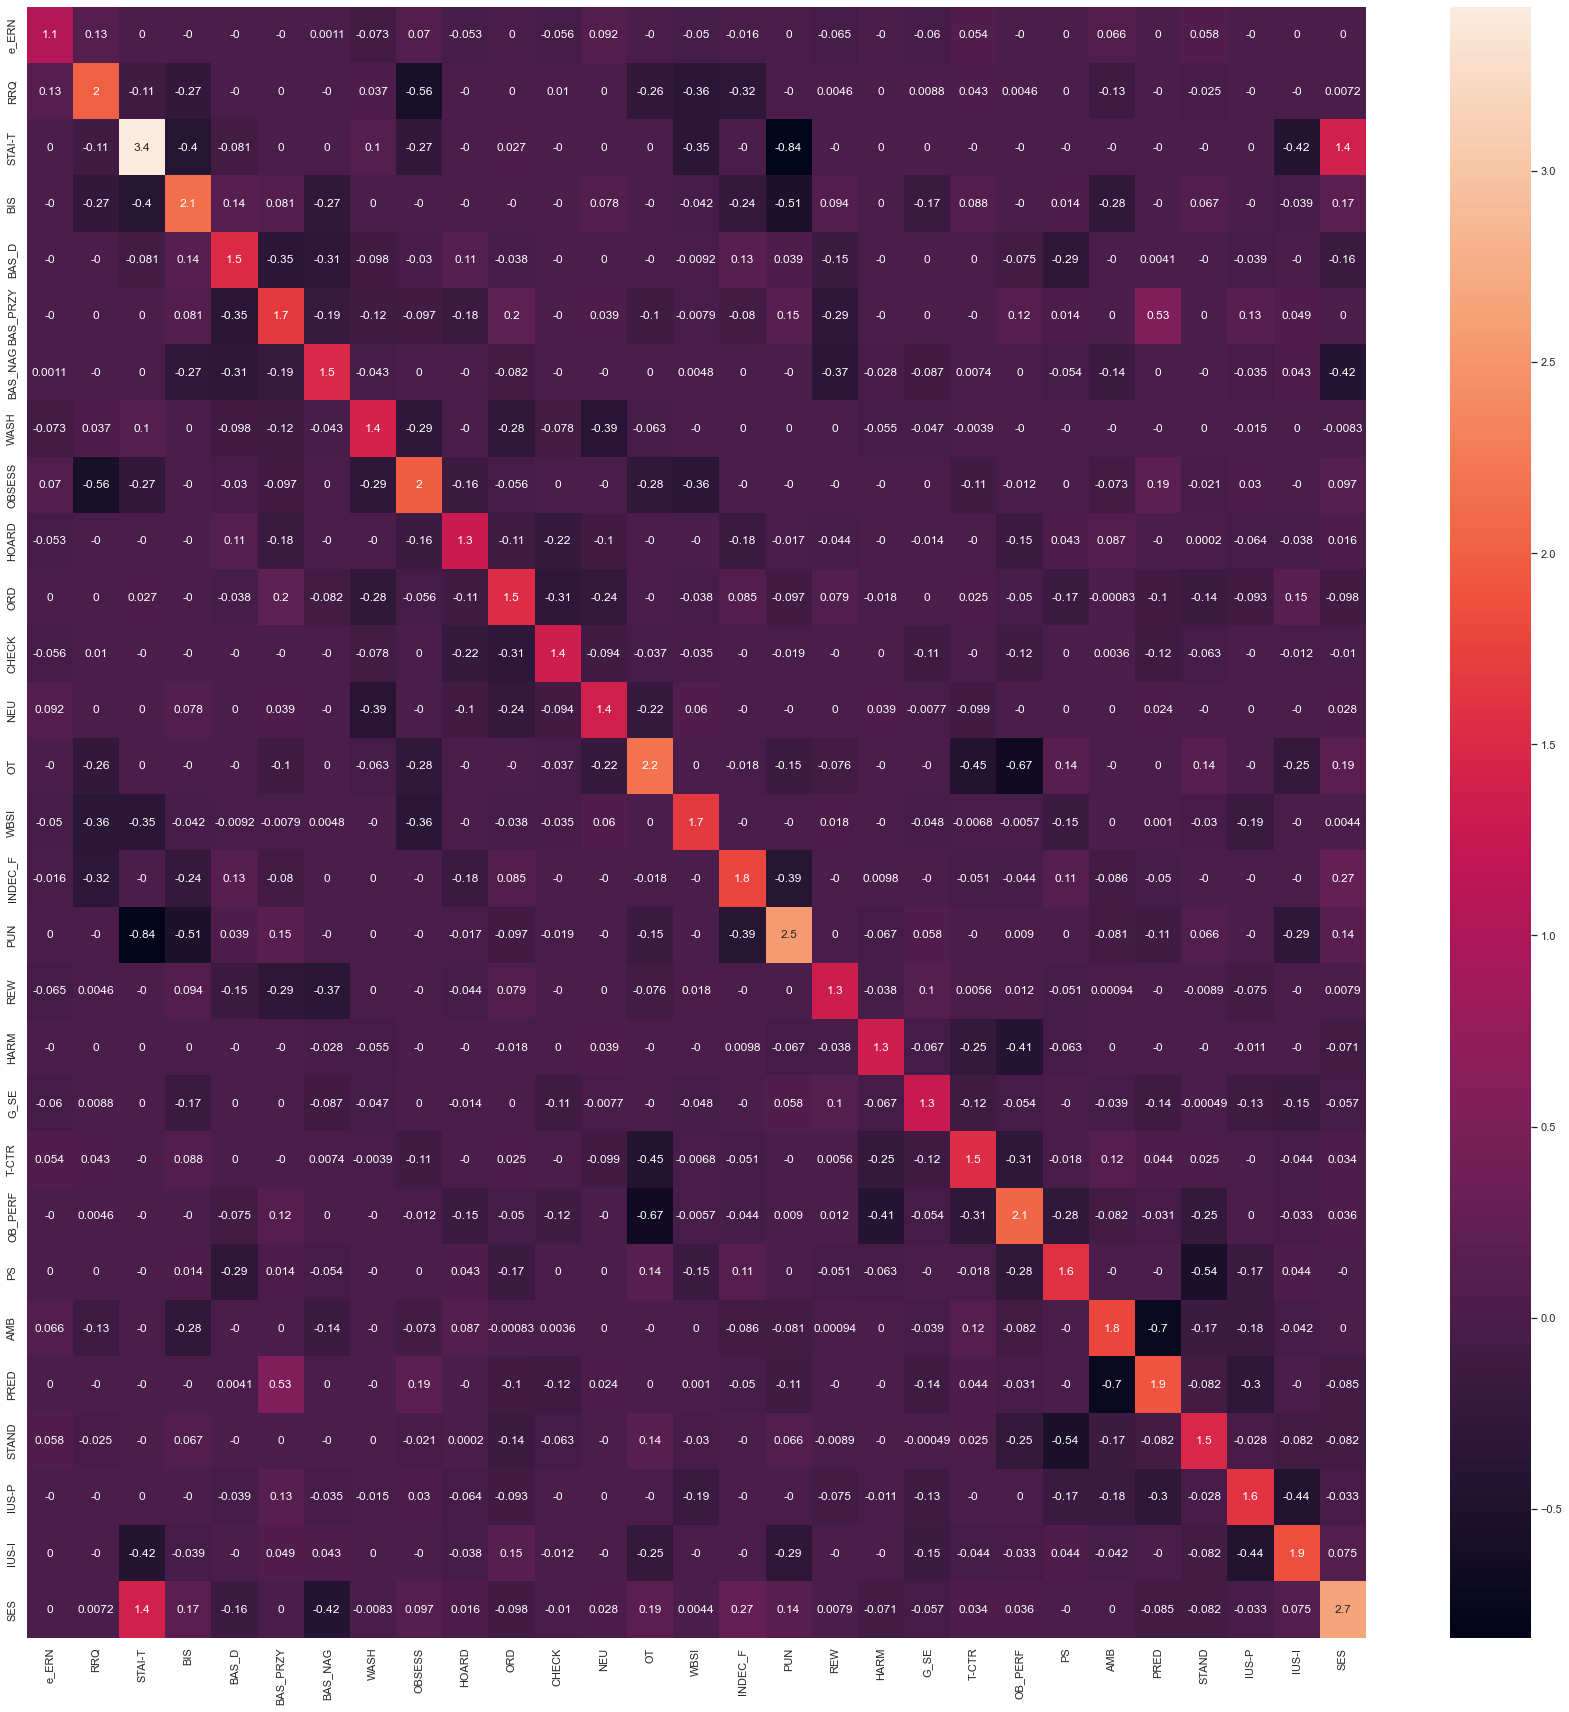

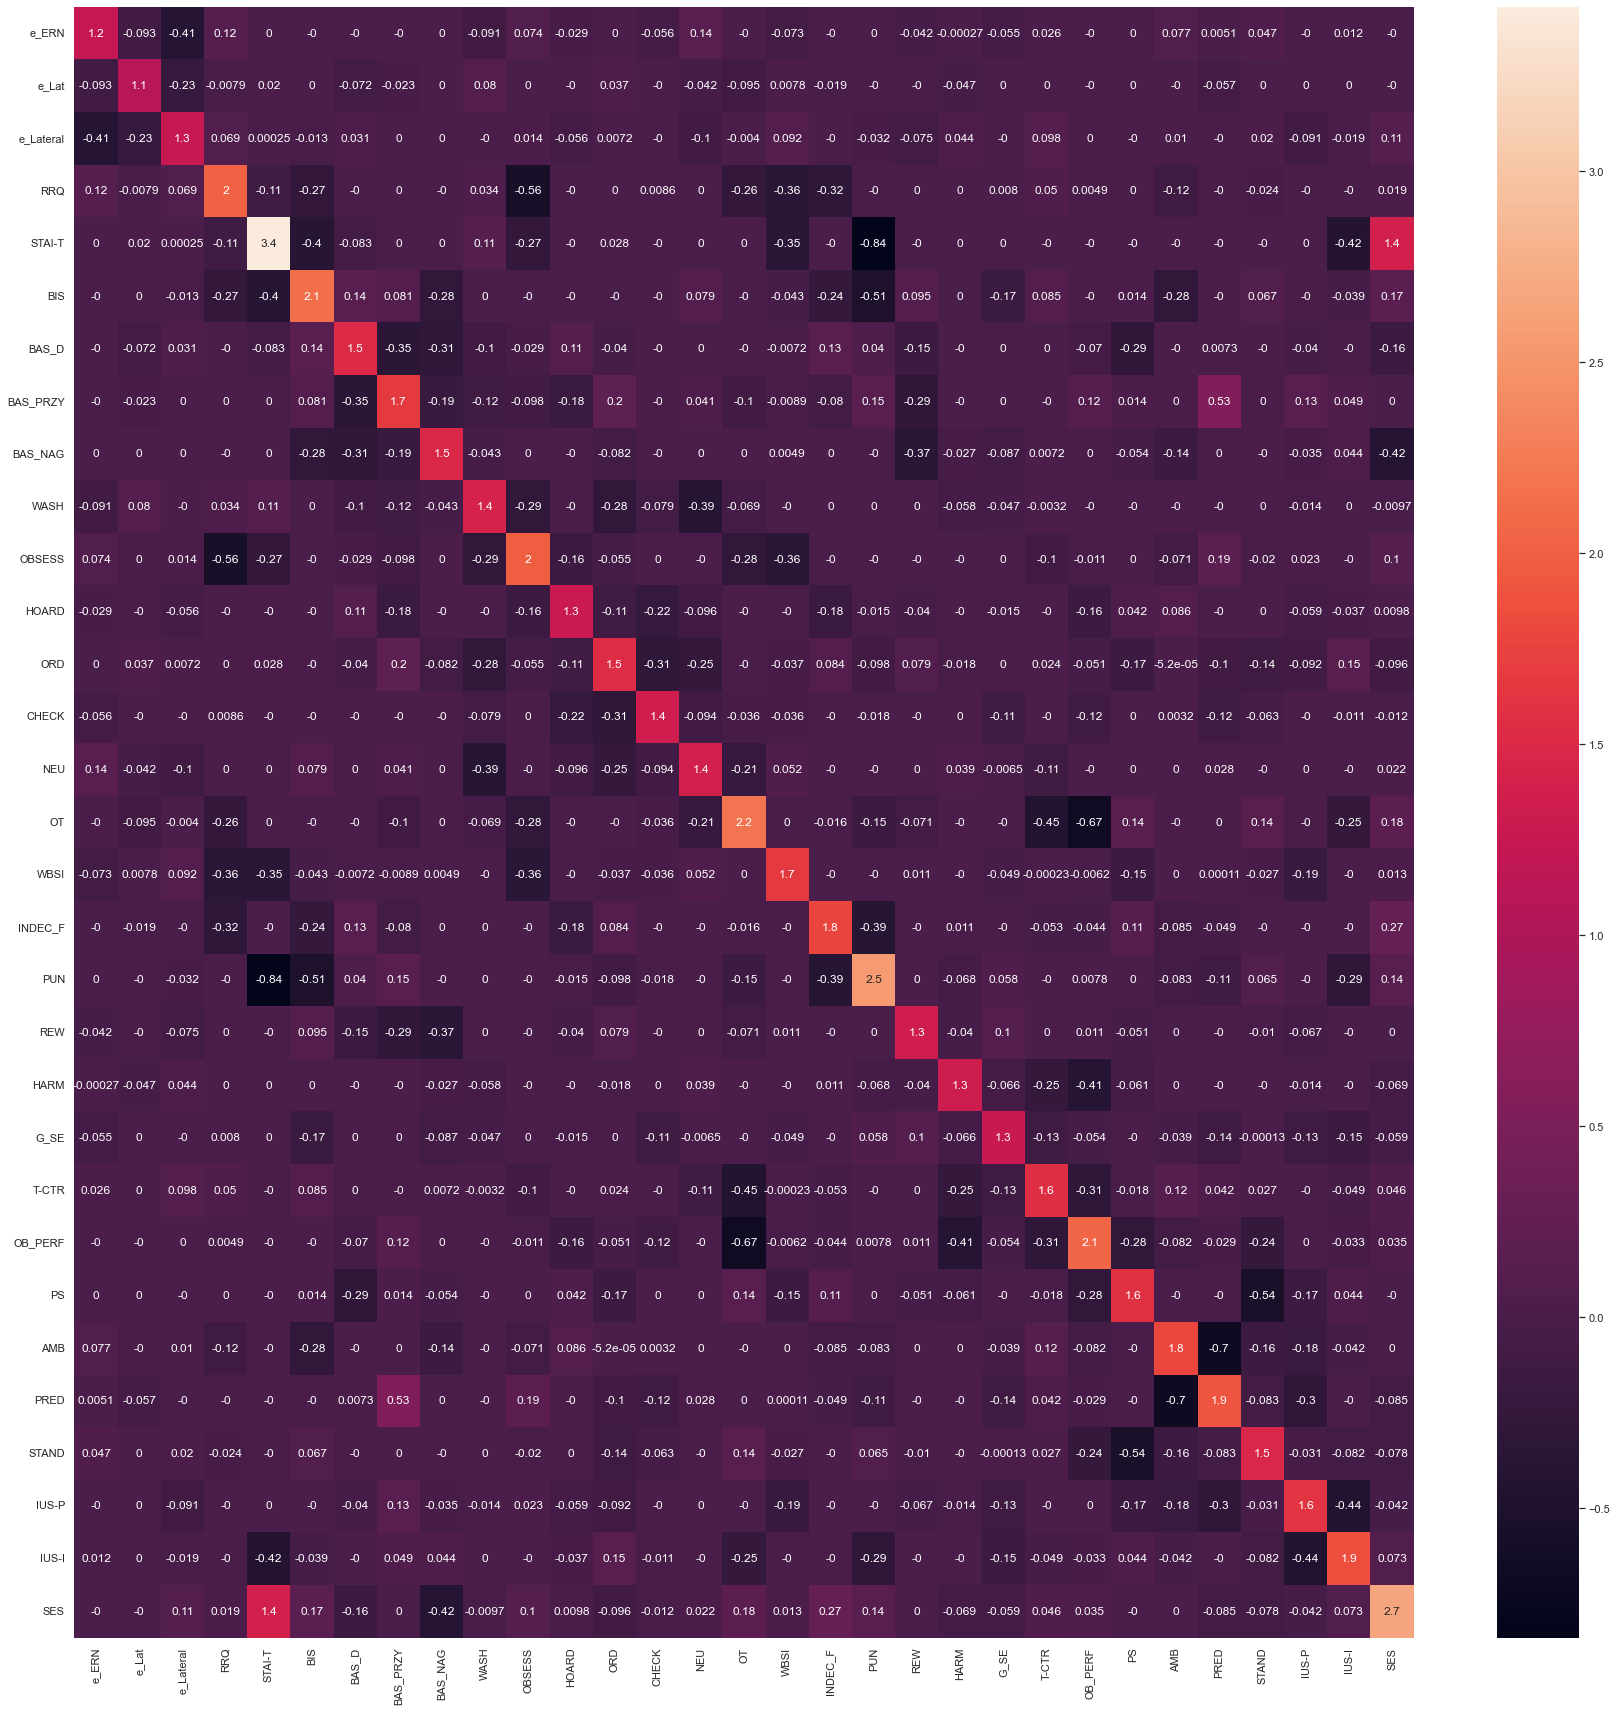

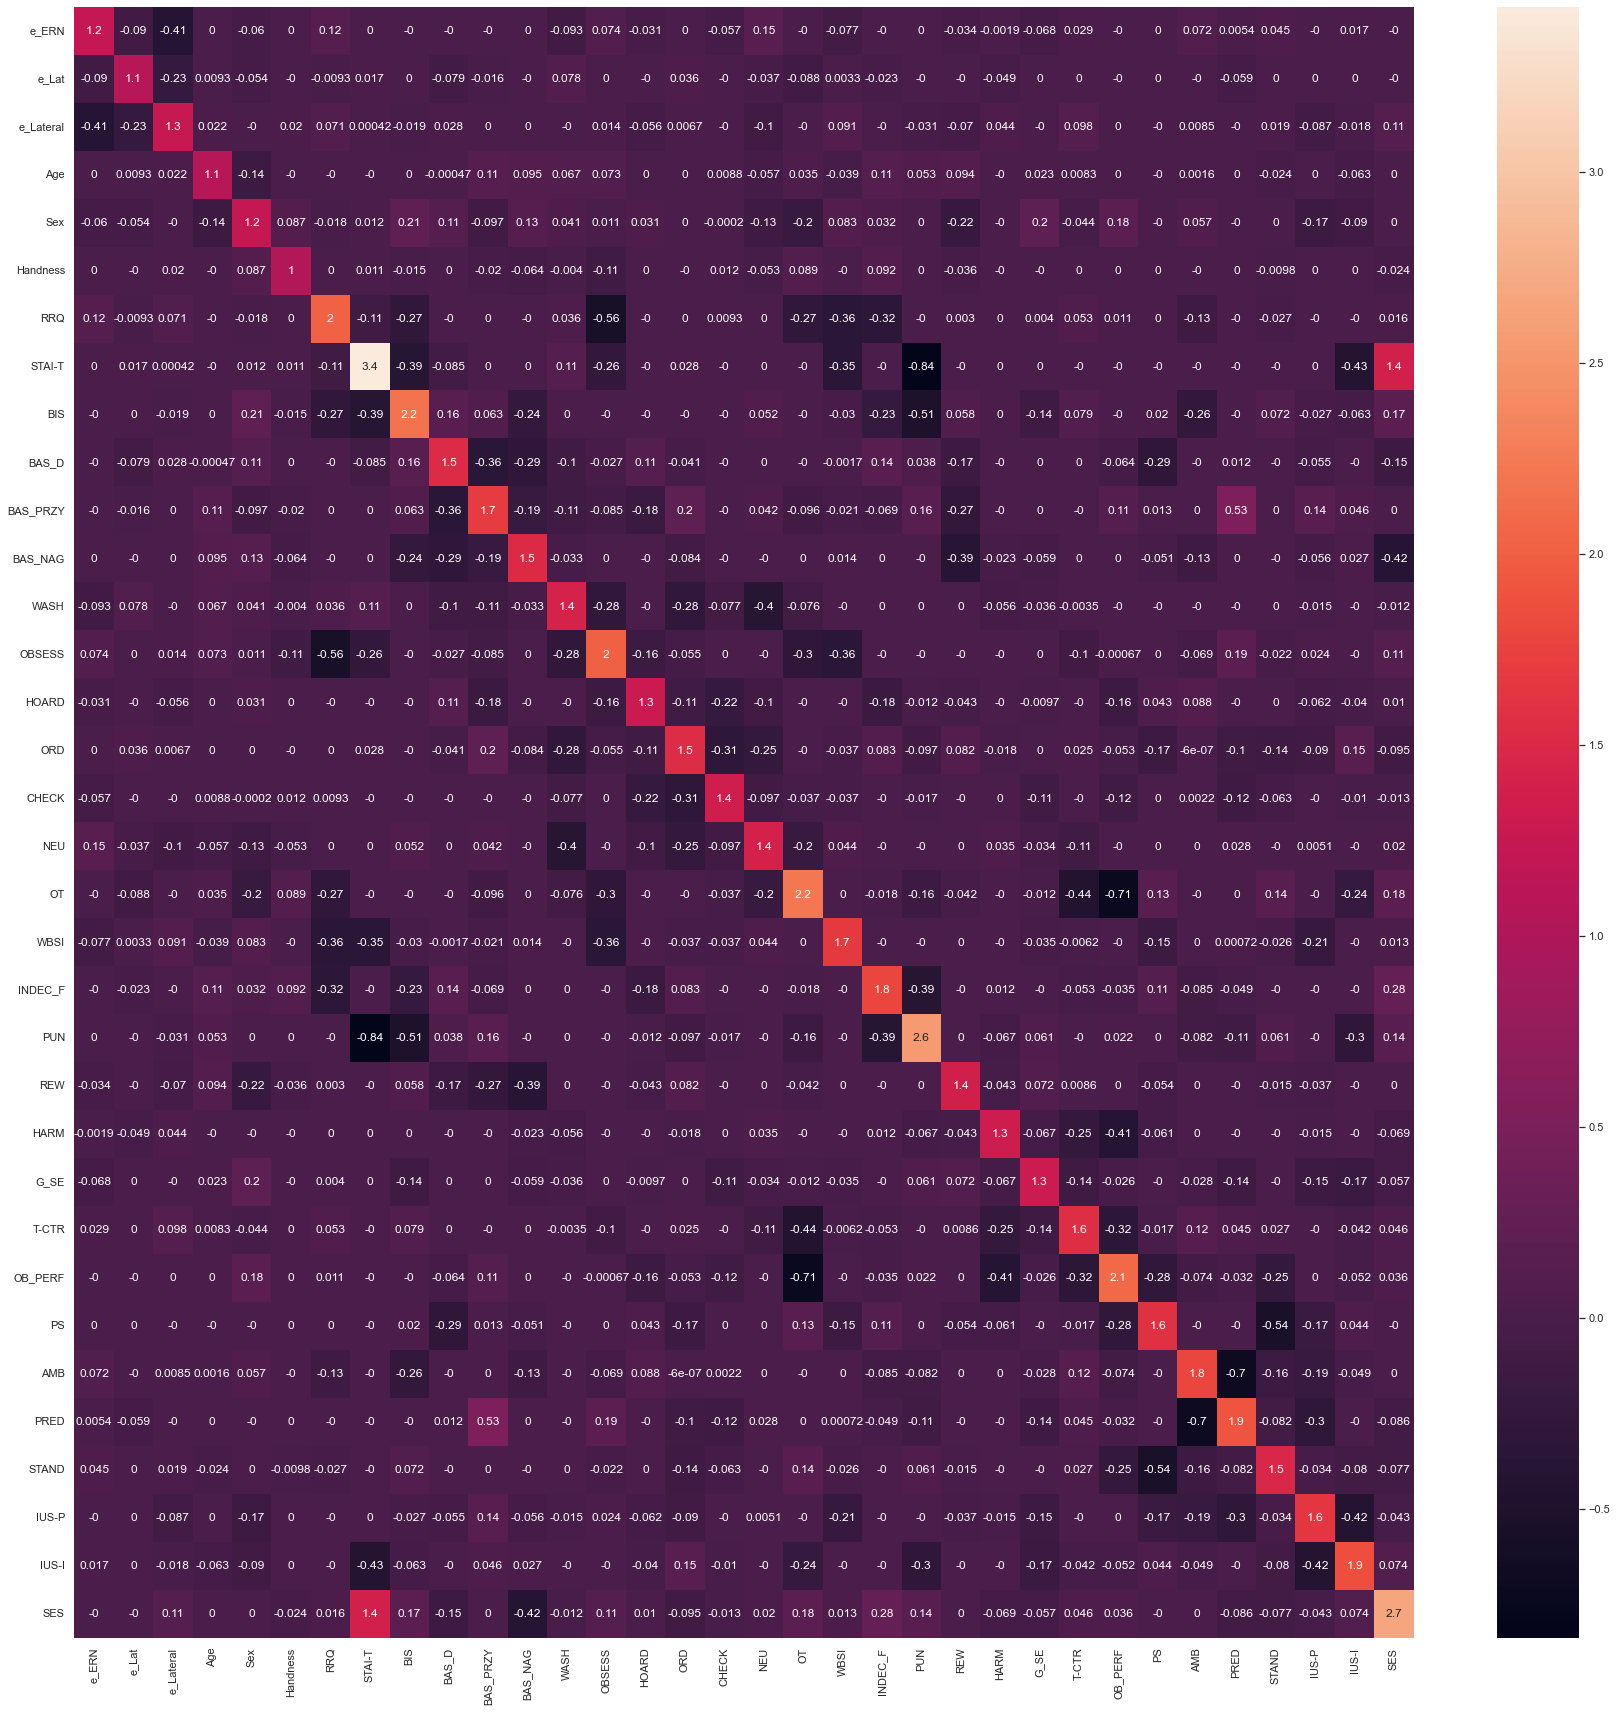

In [105]:
sns.set(rc={'figure.figsize':(30 , 30)})

for i, matrix in enumerate(precision_matrixes):
    plt.figure(i)
    sns.heatmap(
        data = matrix,
        annot=True        
    )

##### Test

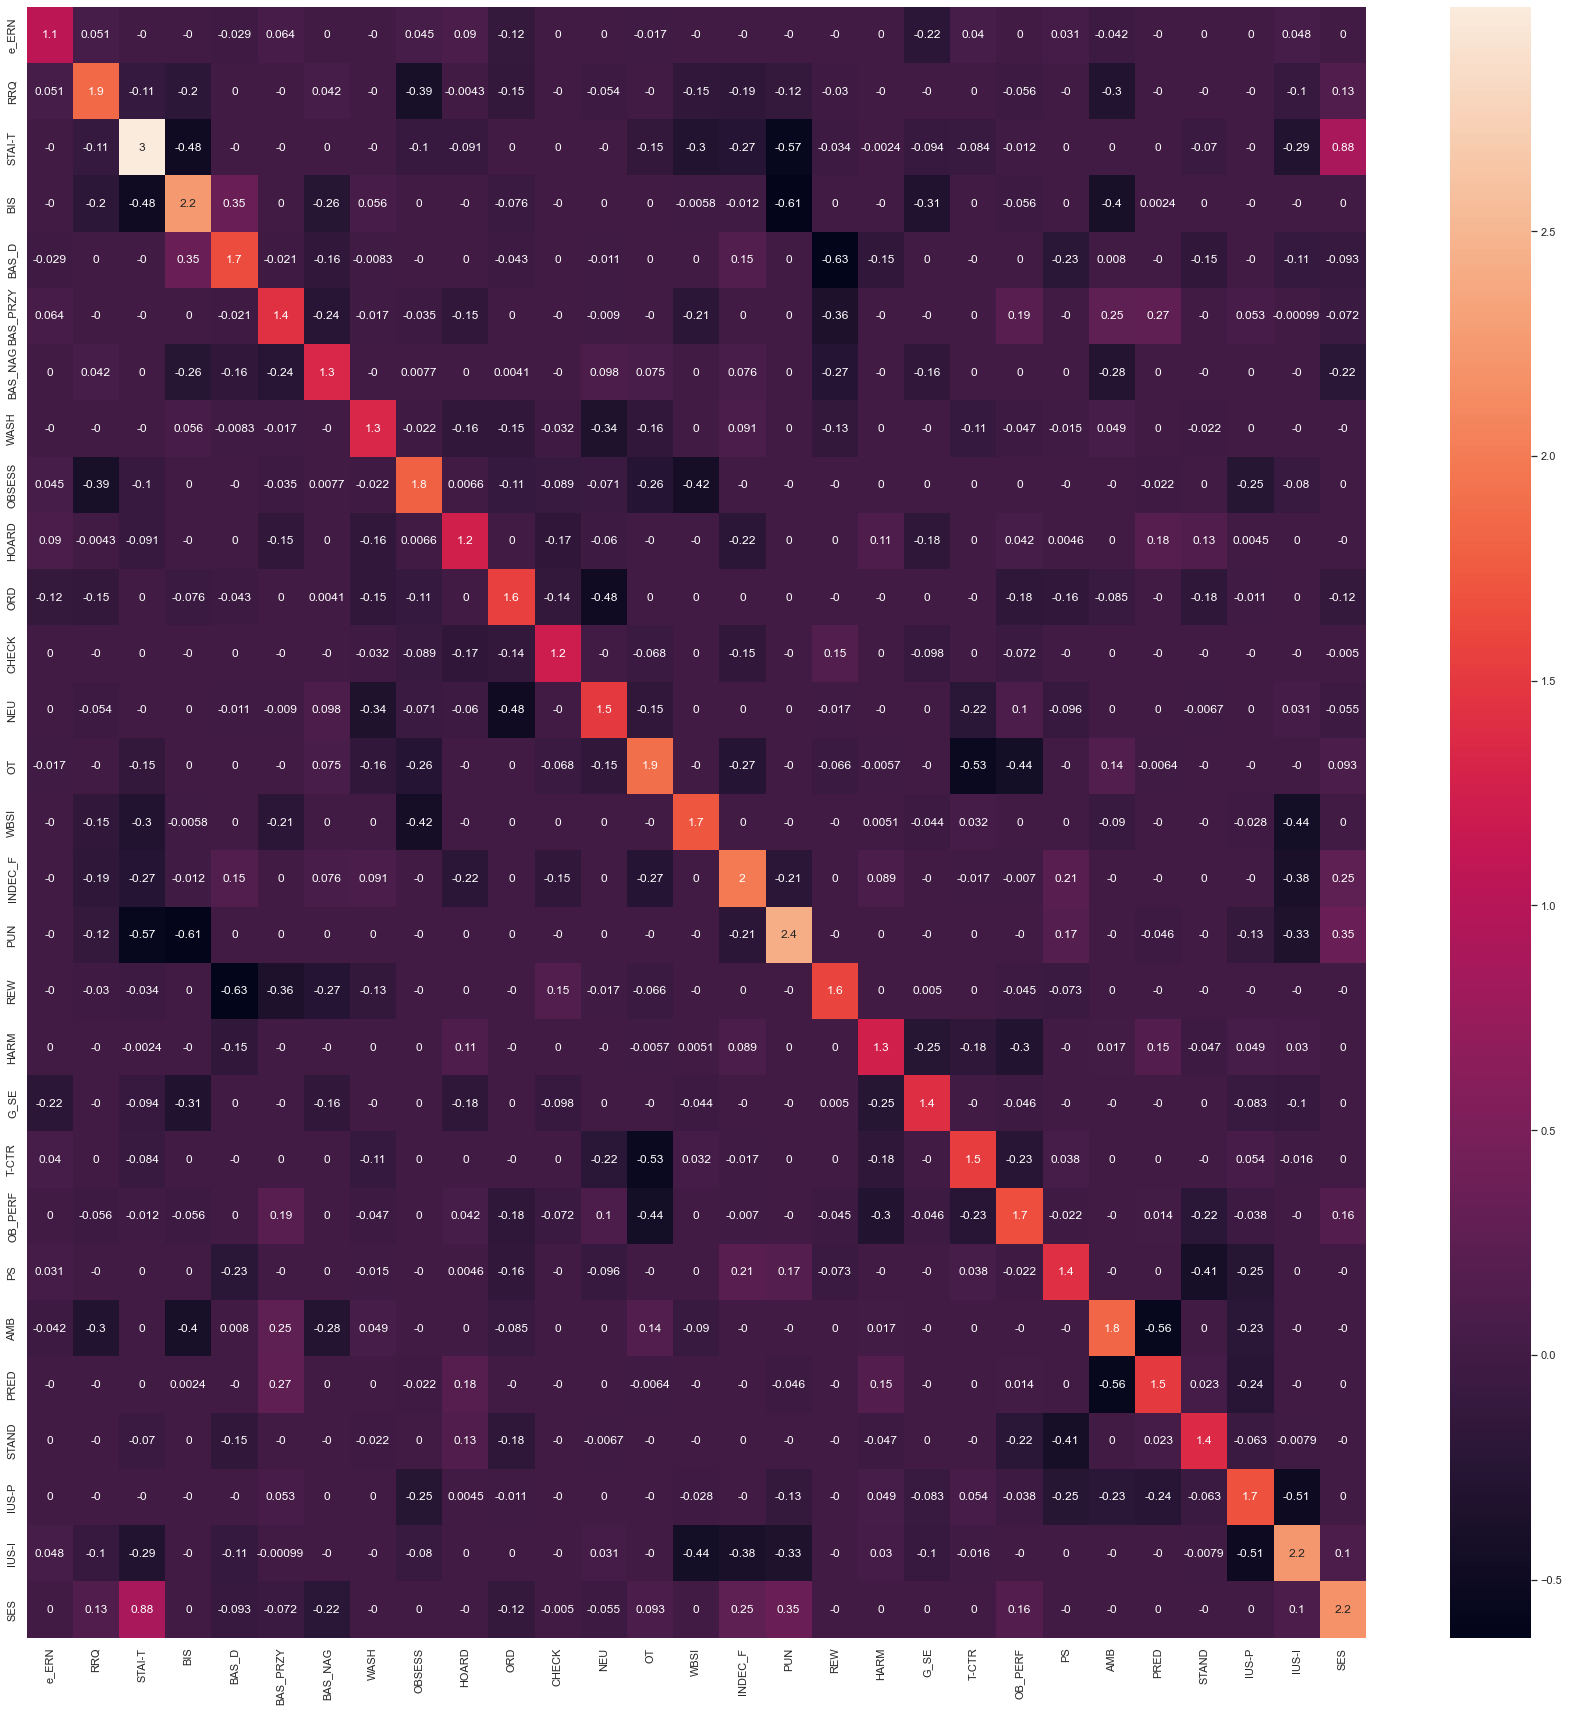

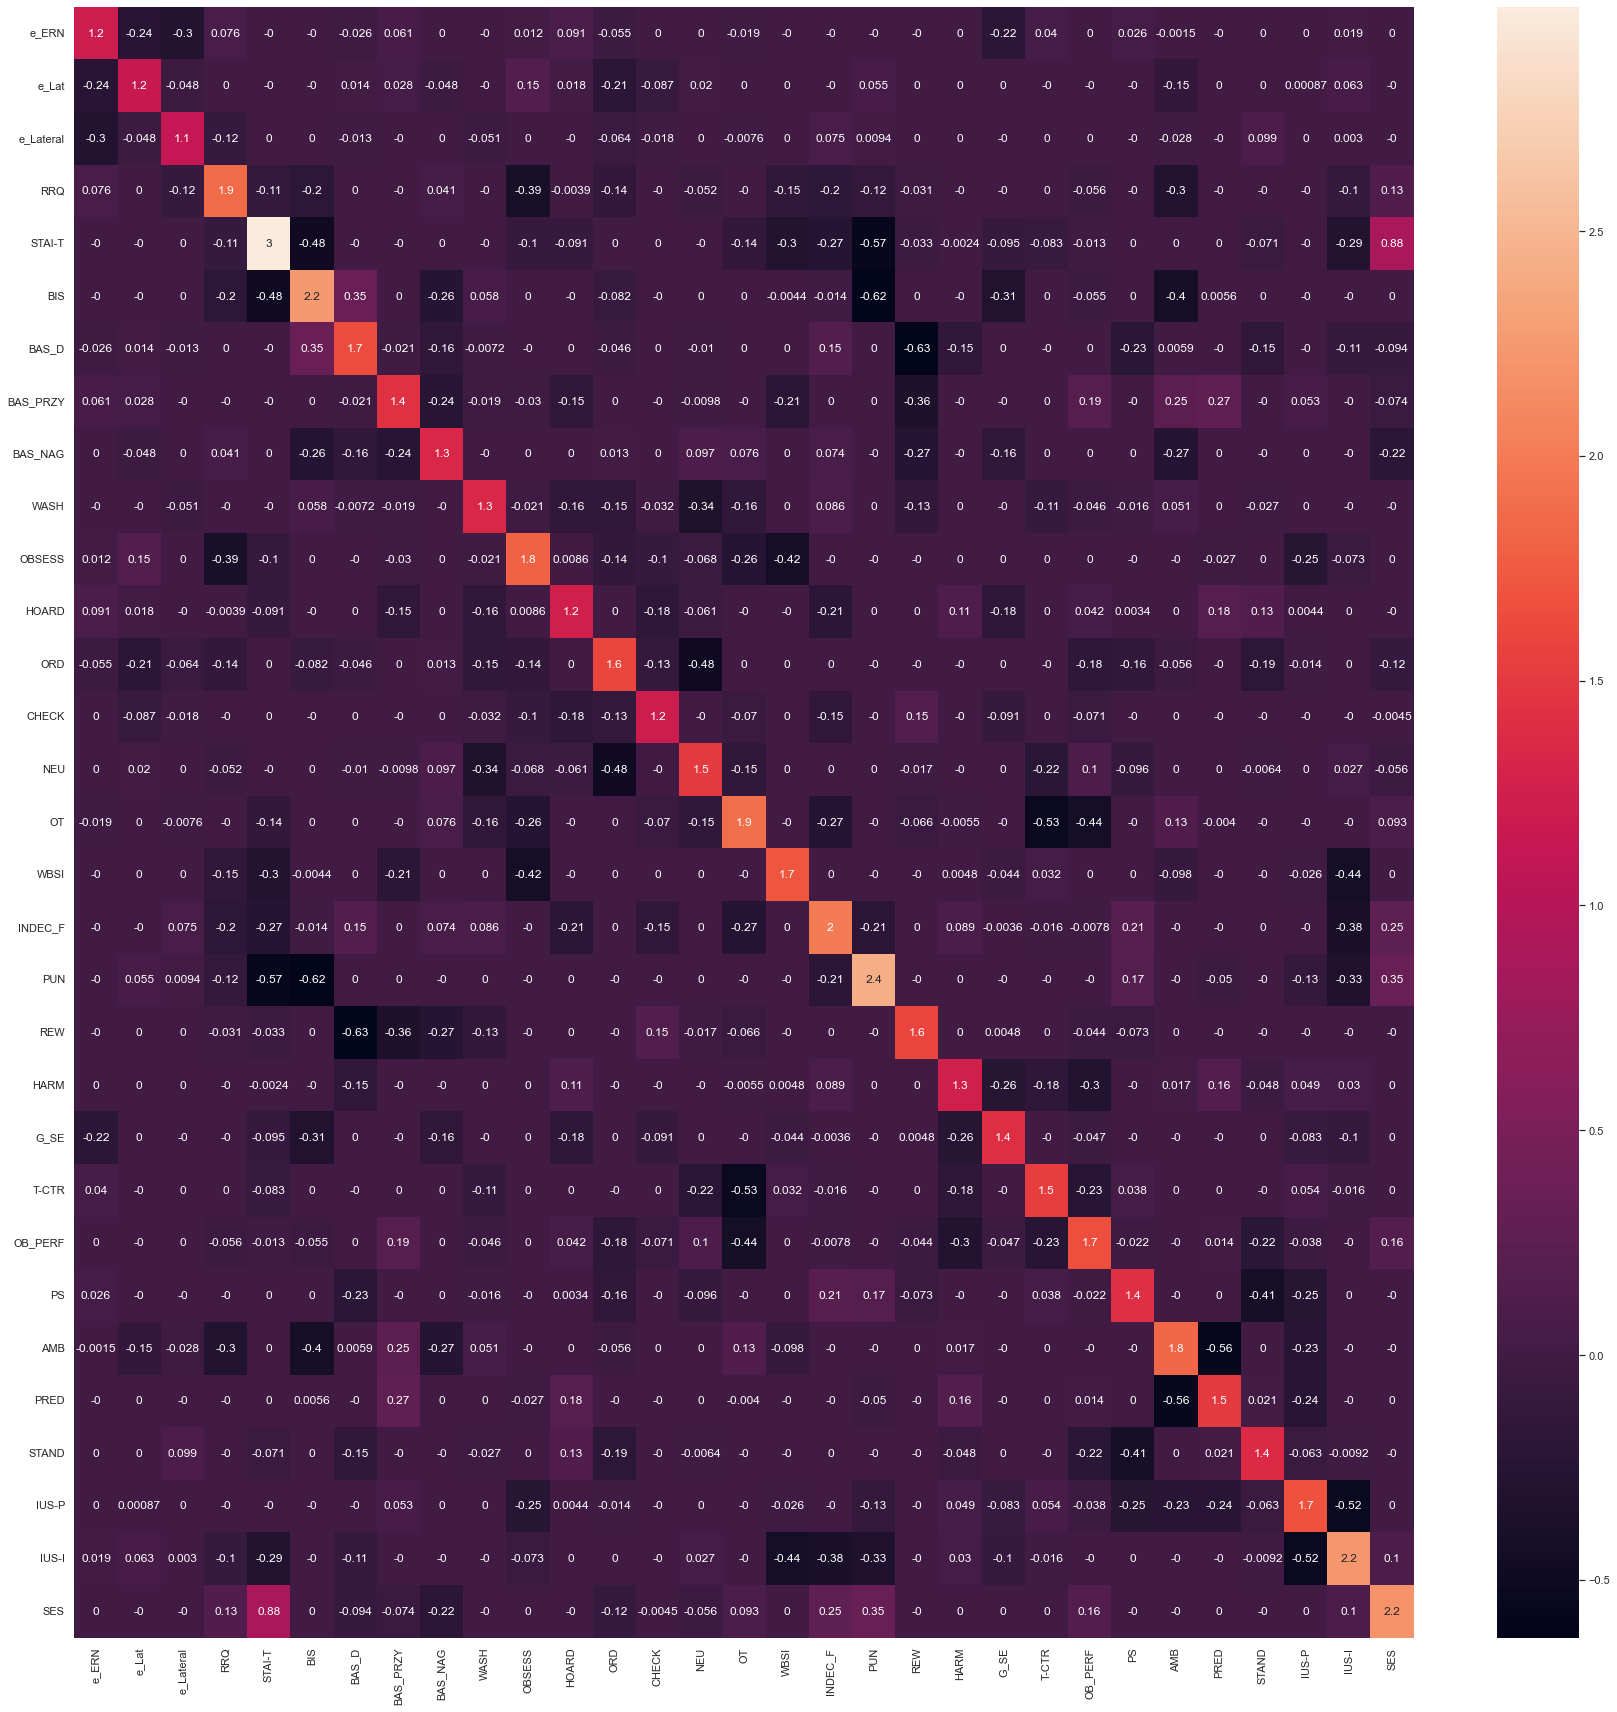

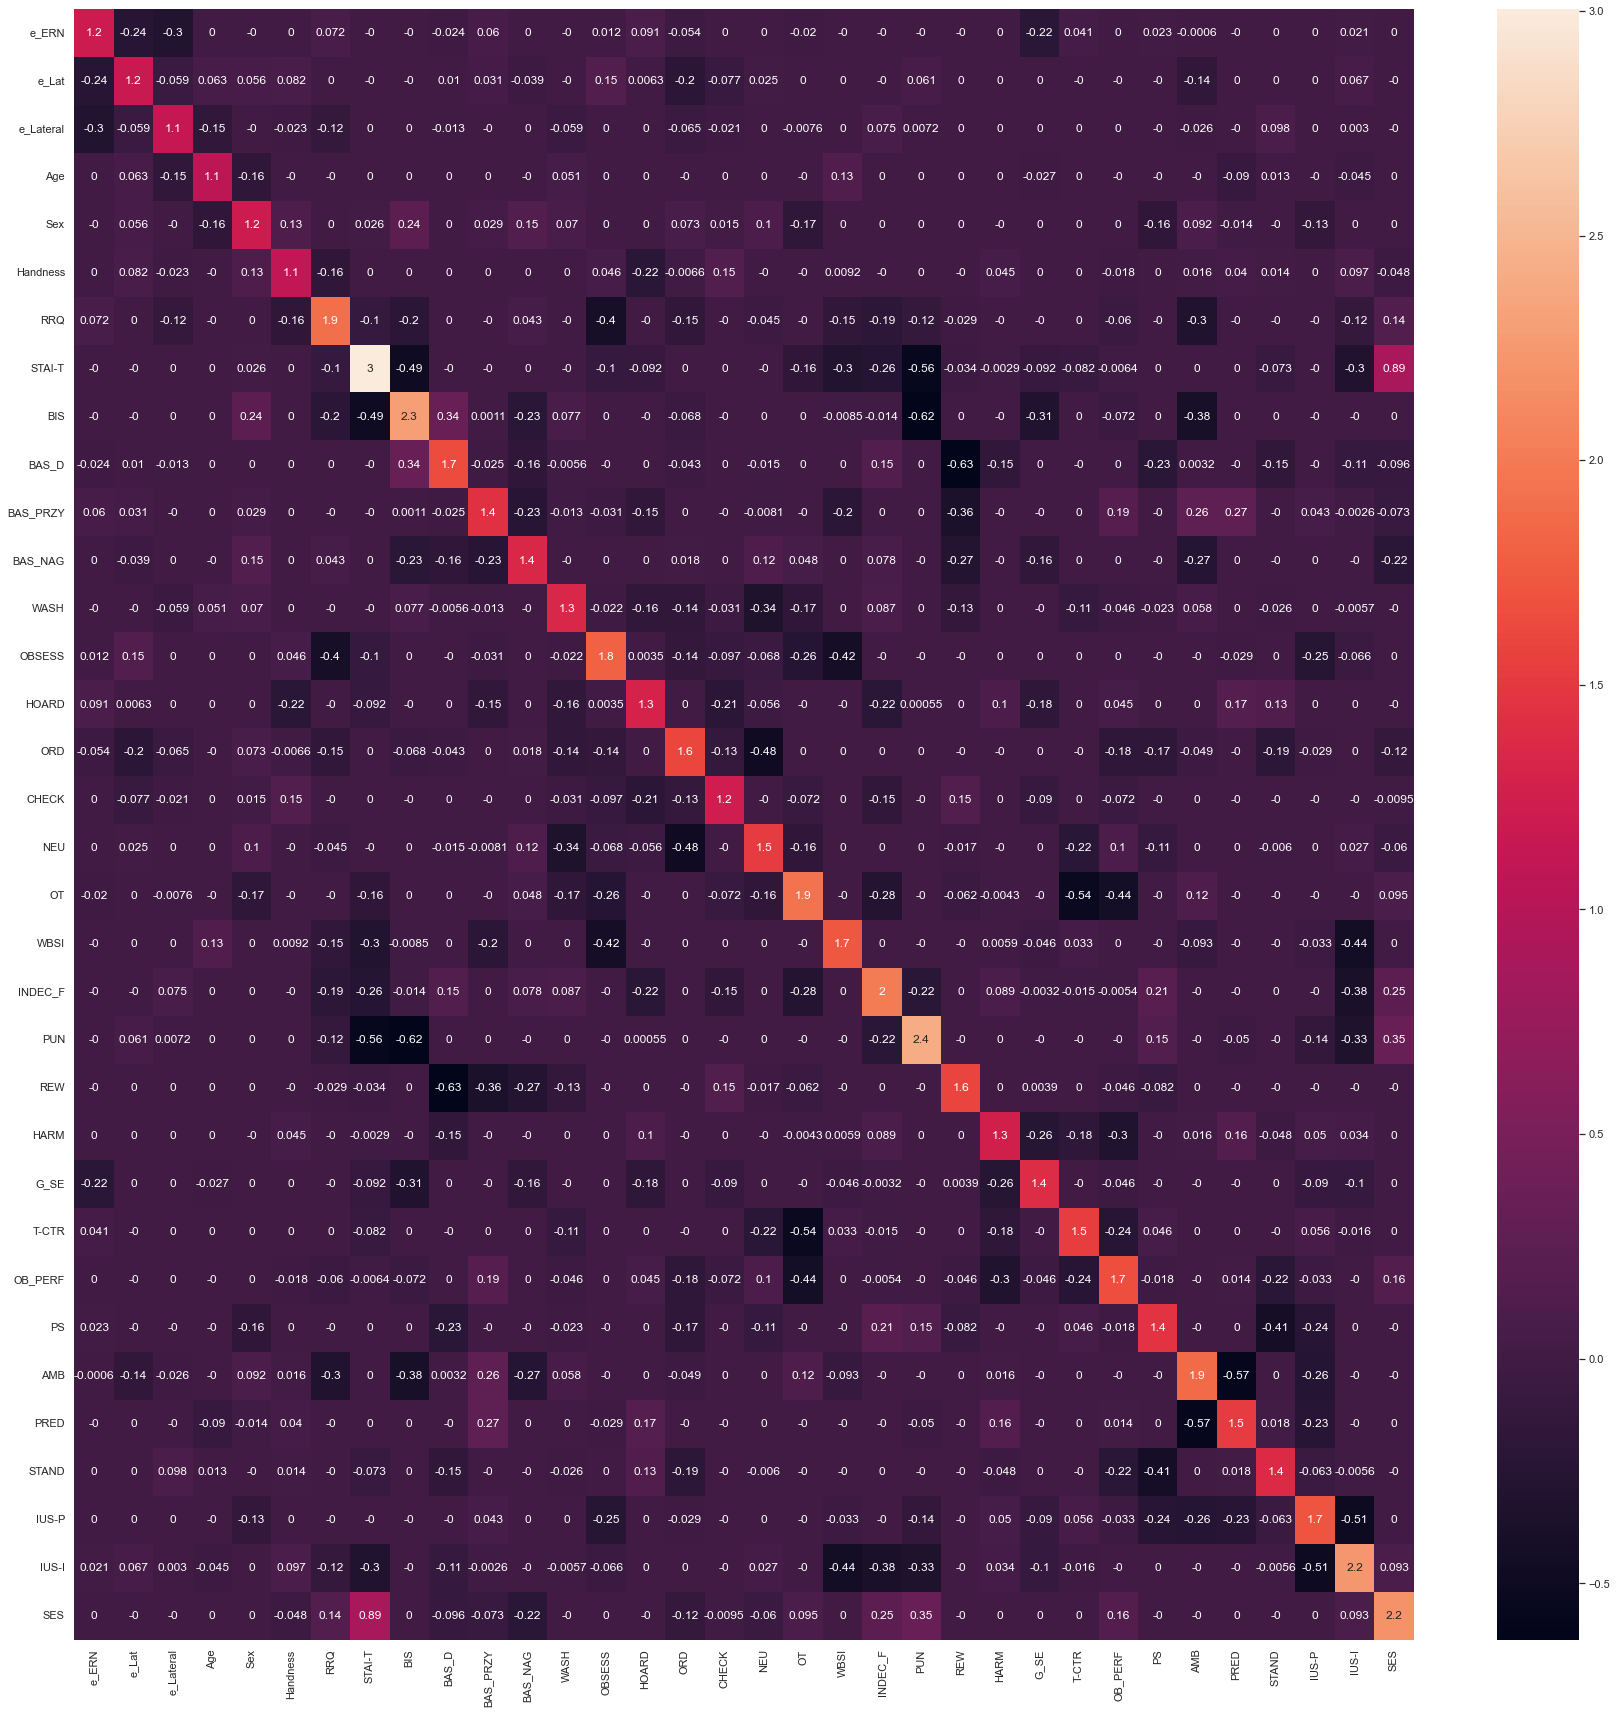

In [192]:
sns.set(rc={'figure.figsize':(30 , 30)})

for i, matrix in enumerate(precision_matrixes_test):
    plt.figure(i)
    sns.heatmap(
        data = matrix,
        annot=True        
    )

## Create graph object

#### Extract links

In [165]:
def get_links(precision_matrix_df, threshold=0.02):
    #prepare the matrix for network illustration
    precision_matrix_df = precision_matrix_df.where(np.triu(np.ones(precision_matrix_df.shape)).astype(np.bool))

    links = precision_matrix_df.stack().reset_index()
    links.columns = ['var1', 'var2','weight']
    links=links.loc[ (abs(links['weight']) > threshold) &  (links['var1'] != links['var2']) ]
    
    # remove links between EEG features for clarity
    links = links[~((links['var1'].str.contains("e_")) & (links['var2'].str.contains("e_")))]
    
    links = links.round(2)
    
    return links

In [166]:
if test:
    pass
else:
    links = []

    for matrix in precision_matrixes:
        this_links = get_links(matrix)
        links.append(this_links)

In [167]:
test_links = []
   
if test:
    for matrix in precision_matrixes_test:
        this_links = get_links(matrix)
        test_links.append(this_links)

In [93]:
# ern_model_links = get_links(precision_matrix_ern_model_df)
# ern_lat_model_links = get_links(precision_matrix_ern_lat_model_df)
# ern_lat_SF_b_model_links = get_links(precision_matrix_ern_lat_SF_b_model_df)
# ern_lat_SF_b_demo_model_links = get_links(precision_matrix_ern_lat_SF_b_demo_model_df)

#### Create graphs

In [94]:
if test:
    pass
else:
    graphs = []

    for this_links in links:    
        G = nx.from_pandas_edgelist(this_links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
        graphs.append(G)

In [95]:
test_graphs = []
    
if test:
    for this_links in test_links:    
        G = nx.from_pandas_edgelist(this_links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
        test_graphs.append(G)

## Visualize graph

#### Leave only N leafs from parent (eeg) nodes

In [112]:
def leave_n_edges_from_eeg(links, N=2):
    parents = set(links[links['var1'].str.contains("e_")]['var1'])

    final_edges = []
    edges_df = pd.DataFrame({})
    leafs = set()

    for parent in parents:
        this_leafs = []

        parent_edges = links[links['var1'] == parent]
        final_edges.append(parent_edges)
        leafs.update(parent_edges['var2'])


    for i in range(1,N+1):
        parents = leafs
        leafs = set()

        for parent in parents:
            parent_edges = links[(links['var1'] == parent) | (links['var2'] == parent)]

            final_edges.append(parent_edges)
            leafs.update(parent_edges['var2'])
            leafs.update(parent_edges['var1'])

    edges_df = pd.concat(final_edges, axis=0, ignore_index=True)
    edges_df = edges_df.drop_duplicates(subset = ["var1", 'var2'])
    
    return edges_df

#### Bulid the graph

In [113]:
def draw_graph(links):
    G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
    
    # set position
    # pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
    pos = nx.circular_layout(G)
    
    labels = nx.get_edge_attributes(G,'weight')
    
    edges_list = list(zip(links.var1.to_list(), links.var2.to_list()))
    edge_color = [('blue' if edge < 0 else 'red') for edge in links.weight.to_list()]
    
    weights = links.weight.to_list()
    weights_alphas = []
    weight_bold = []

    for edge_weight in weights:
        if abs(edge_weight) < 0.2:
            alpha = 0.2 
            bold = 4
        elif abs(edge_weight) >= 0.2 and abs(edge_weight) < 0.4:
            alpha = 0.4
            bold = 7
        elif abs(edge_weight) >= 0.4 and abs(edge_weight) < 0.7:
            alpha = 0.7
            bold = 10
        else:
            alpha = 0.9
            bold = 15
        weights_alphas.append(alpha)
        weight_bold.append(bold)
        
    plt.figure(3, figsize=(30, 30))

    nx.draw_networkx_nodes(
        G, 
        pos=pos, 
        node_size = 10000,
    )

    nx.draw_networkx_labels(
        G, 
        pos=pos,
        font_size=20,

    )

    nx.draw_networkx_edges(
        G, 
        pos=pos,
        edgelist = edges_list,
        edge_color = edge_color,
        alpha=weights_alphas,
        width = weight_bold,
    )

    plt.show()   

- Train

<Figure size 2160x2160 with 0 Axes>

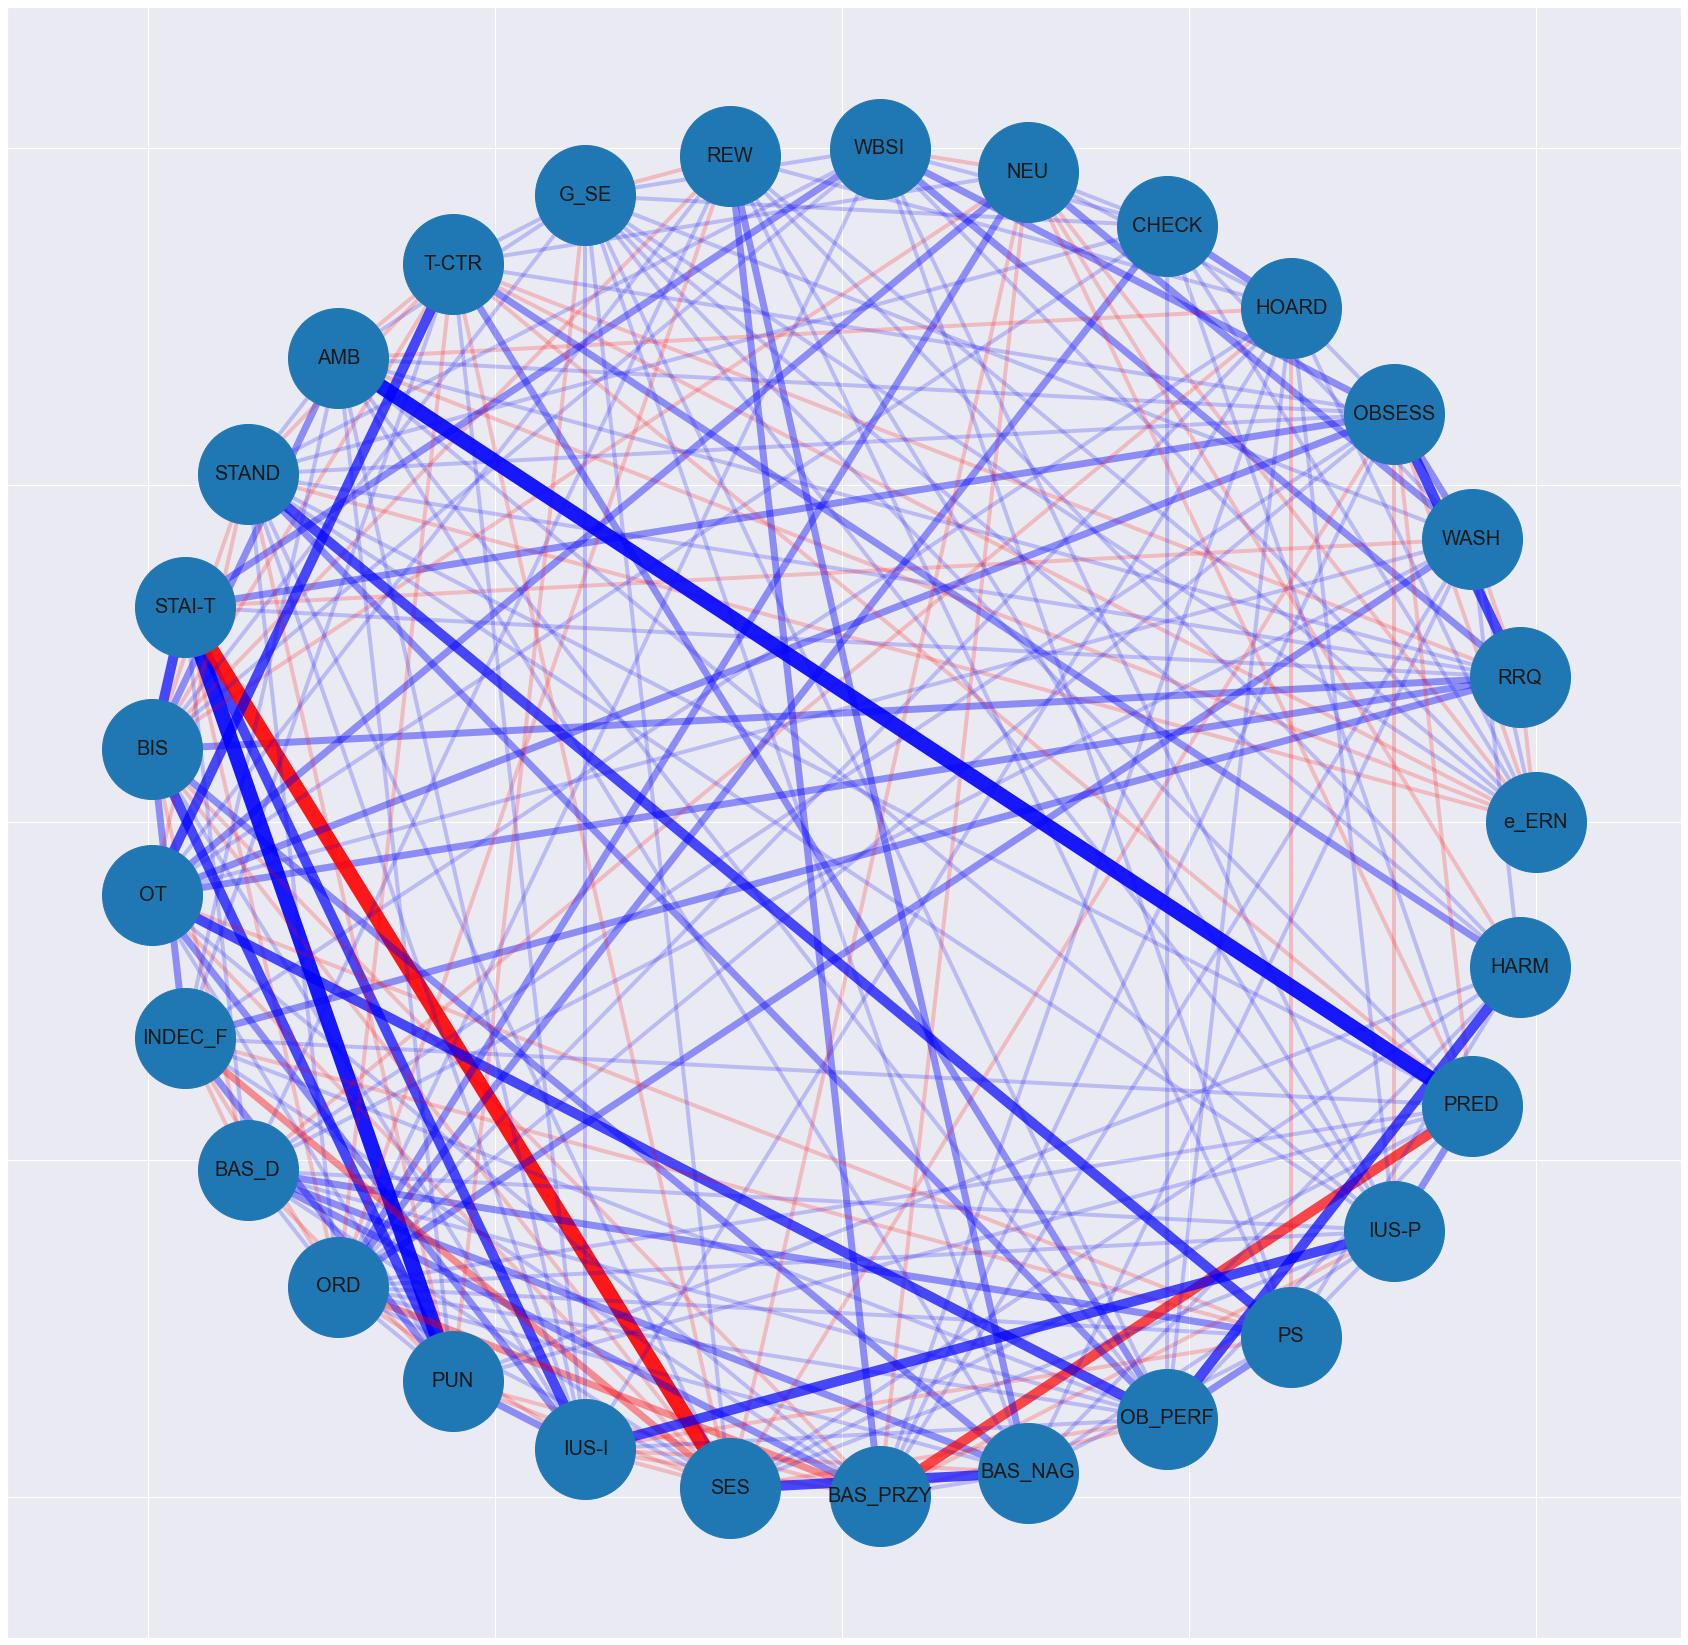

<Figure size 2160x2160 with 0 Axes>

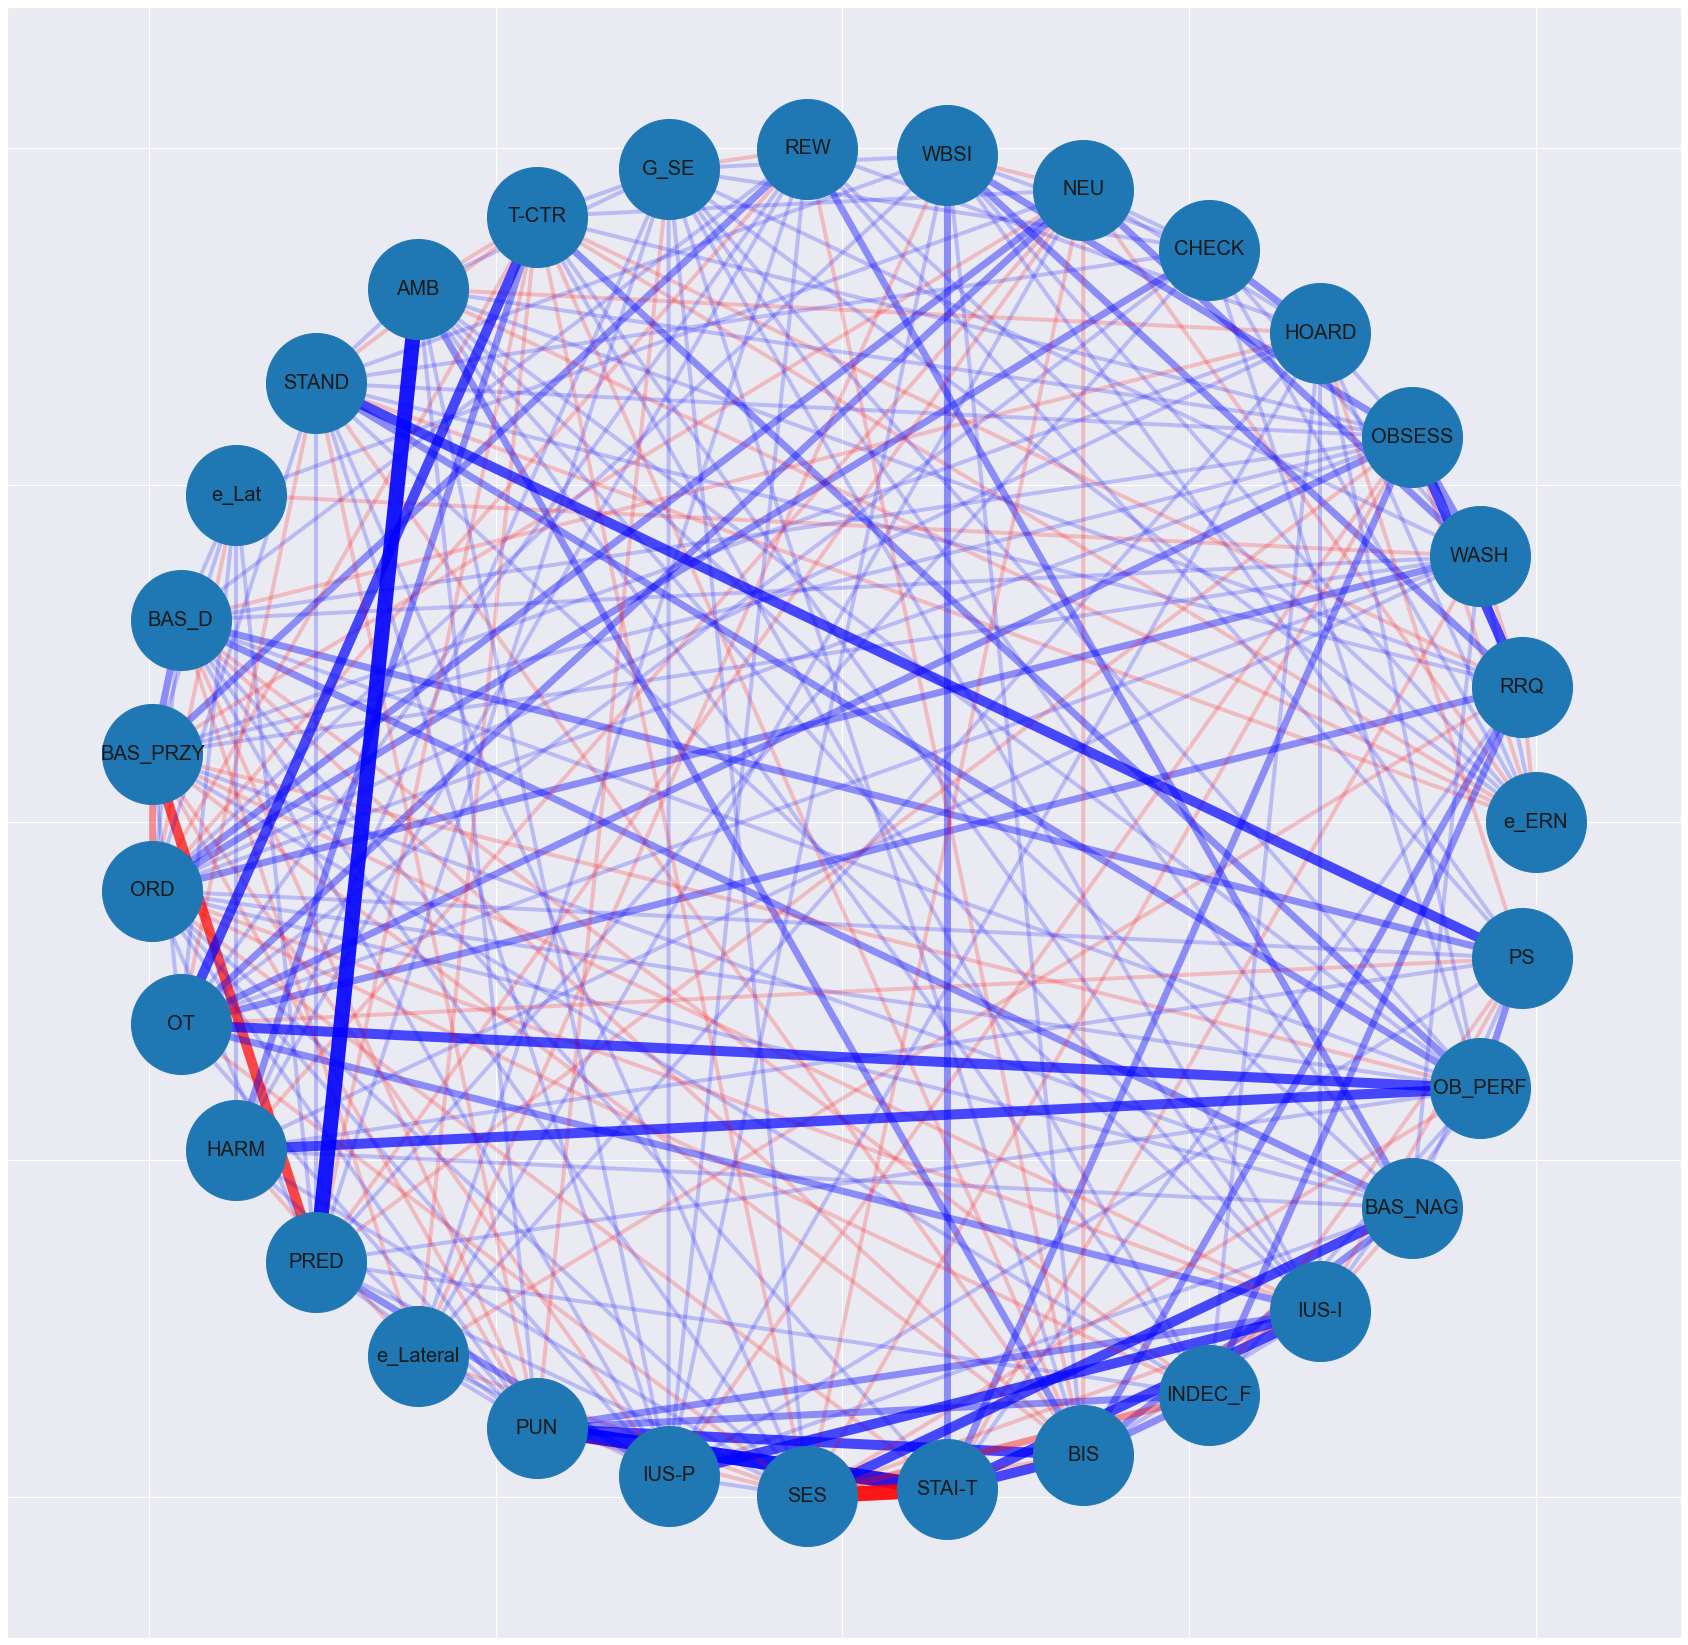

<Figure size 2160x2160 with 0 Axes>

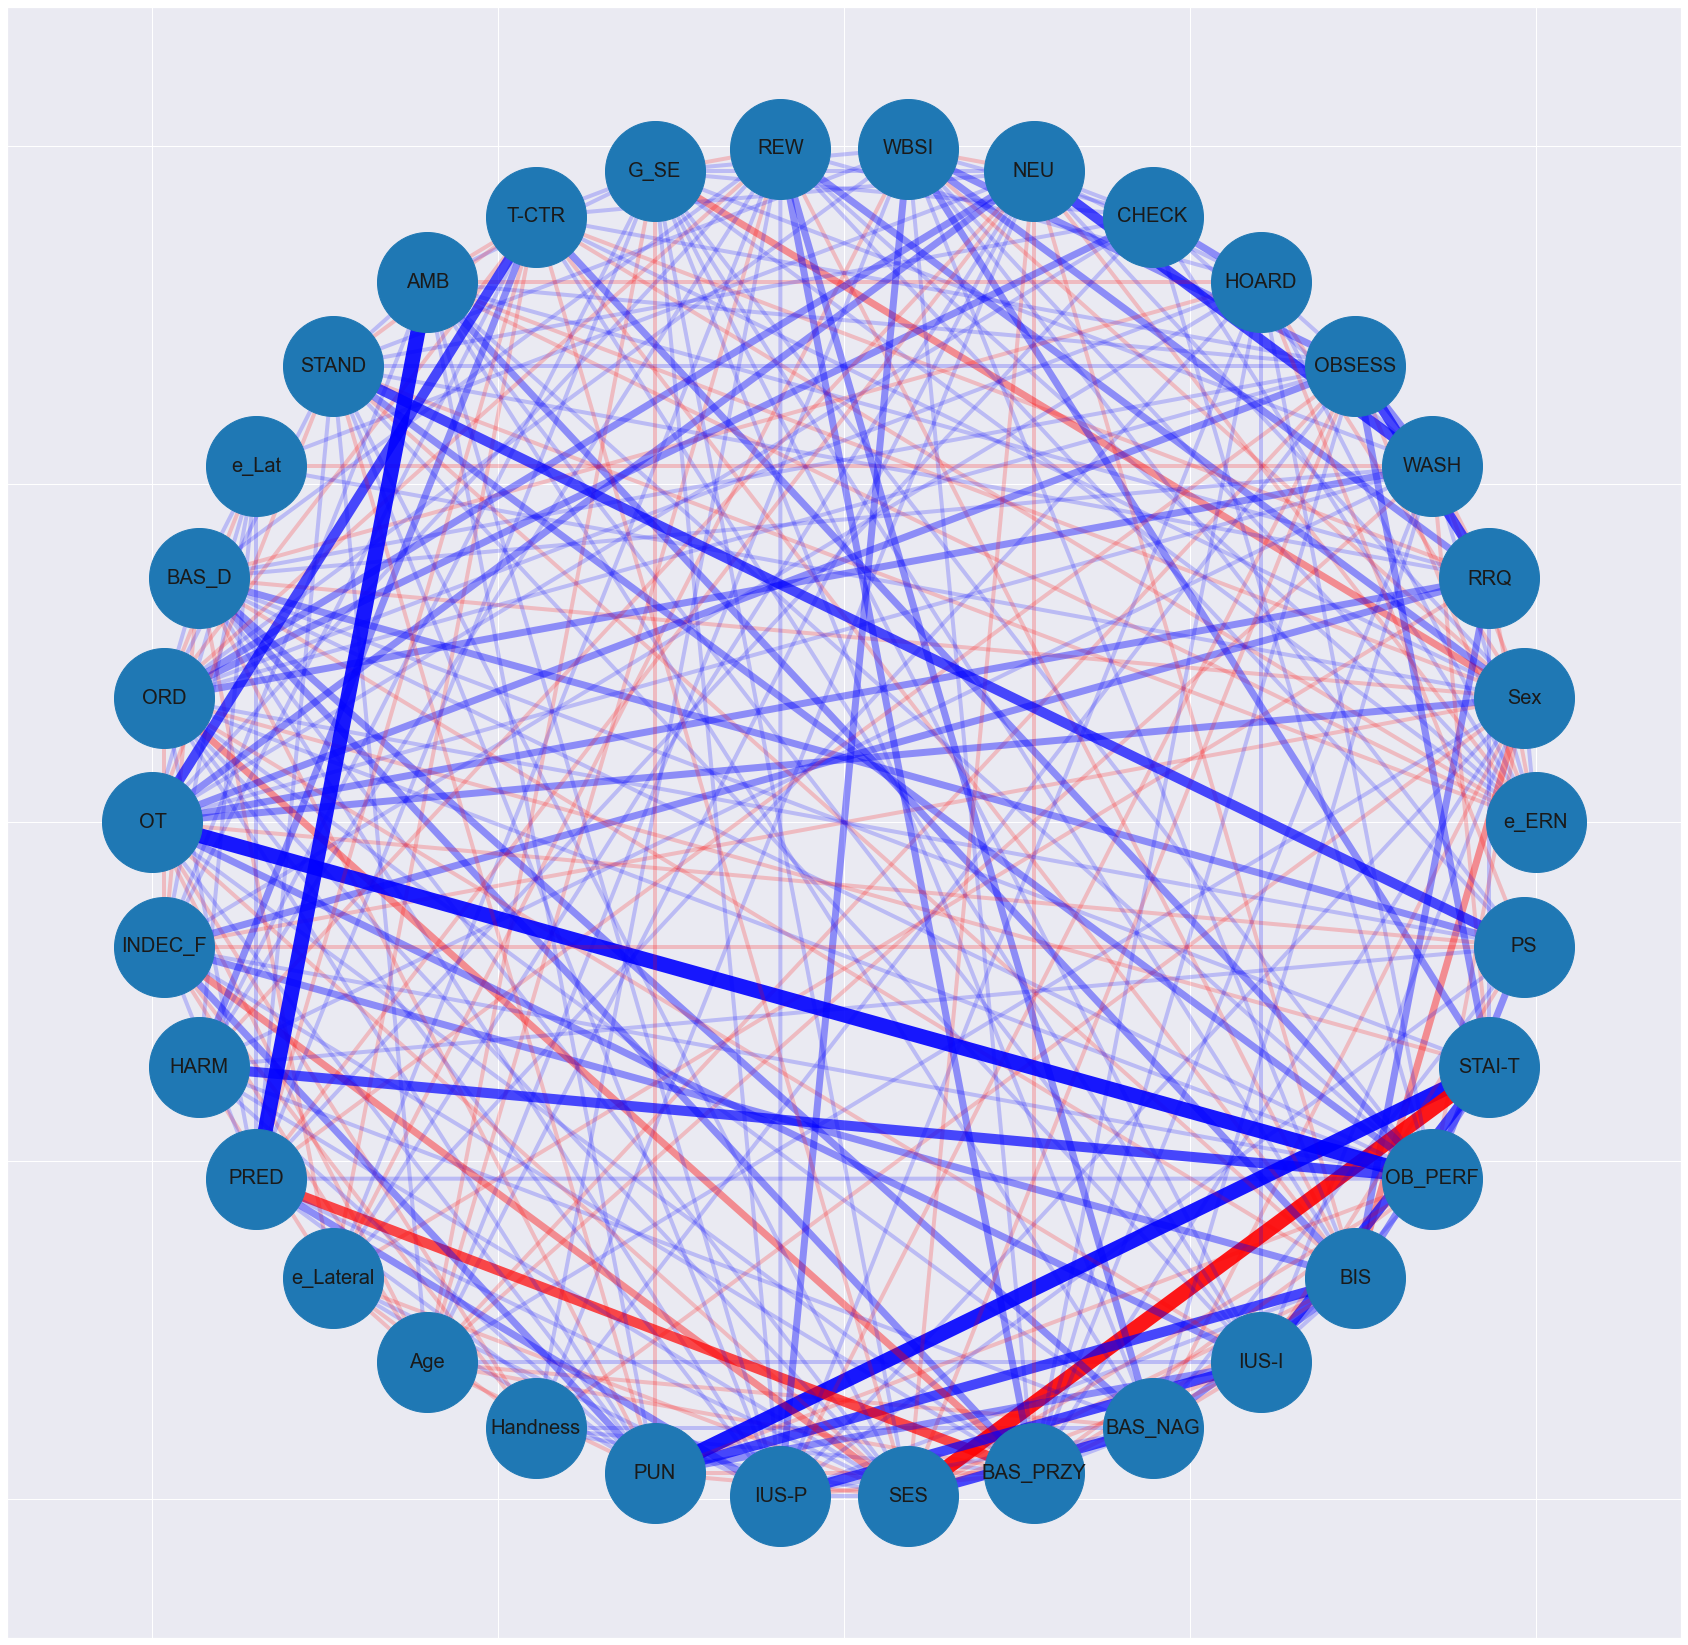

In [114]:
sns.set(rc={'figure.figsize':(30 , 30)})

for i, this_links in enumerate(links):
    plt.figure(i)
    draw_graph(this_links)

- Test

In [116]:
sns.set(rc={'figure.figsize':(30 , 30)})

if test:   
    for i, this_links in enumerate(links_test):
        plt.figure(i)
        draw_graph(this_links)

---
## Centrality measures

ERN model

In [133]:
G_ern = nx.from_pandas_edgelist(ern_model_links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
deg_centrality = nx.degree_centrality(G_ern)

deg_centrality

{'e_ERN': 0.2777777777777778,
 'STAI-T': 0.7222222222222222,
 'OBSESS': 0.6666666666666666,
 'HOARD': 0.5555555555555556,
 'ORD': 0.8333333333333333,
 'IUS-I': 0.6666666666666666,
 'RRQ': 0.5555555555555556,
 'BIS': 0.6666666666666666,
 'BAS_PRZY': 0.8333333333333333,
 'CHECK': 0.5555555555555556,
 'OT': 0.611111111111111,
 'OB_PERF': 0.611111111111111,
 'WBSI': 0.611111111111111,
 'BAS_D': 0.6666666666666666,
 'BAS_NAG': 0.4444444444444444,
 'WASH': 0.611111111111111,
 'SES': 0.6666666666666666,
 'IUS-P': 0.611111111111111,
 'NEU': 0.2777777777777778}

ERN Latency Lateralization model

In [134]:
G_ern_lat = nx.from_pandas_edgelist(ern_lat_model_links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
deg_centrality = nx.degree_centrality(G_ern_lat)

deg_centrality

{'e_ERN': 0.15000000000000002,
 'STAI-T': 0.5,
 'OBSESS': 0.45,
 'IUS-I': 0.6000000000000001,
 'e_Lat': 0.15000000000000002,
 'WASH': 0.5,
 'CHECK': 0.4,
 'NEU': 0.35000000000000003,
 'e_Lateral': 0.2,
 'HOARD': 0.5,
 'IUS-P': 0.5,
 'RRQ': 0.30000000000000004,
 'BIS': 0.5,
 'OT': 0.55,
 'WBSI': 0.45,
 'SES': 0.45,
 'BAS_D': 0.5,
 'BAS_PRZY': 0.6000000000000001,
 'BAS_NAG': 0.25,
 'ORD': 0.65,
 'OB_PERF': 0.45}

ERN Lateralization Latency SF bins model

In [135]:
G_ern_lat = nx.from_pandas_edgelist(ern_lat_SF_b_model_links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
deg_centrality = nx.degree_centrality(G_ern_lat)

deg_centrality

{'e_ERN': 0.09090909090909091,
 'OBSESS': 0.4090909090909091,
 'IUS-I': 0.5454545454545454,
 'e_PCA_1_6': 0.18181818181818182,
 'RRQ': 0.3181818181818182,
 'ORD': 0.6363636363636364,
 'IUS-P': 0.5,
 'SES': 0.4545454545454546,
 'e_PCA_2_6': 0.045454545454545456,
 'WBSI': 0.4545454545454546,
 'e_Lat': 0.13636363636363635,
 'WASH': 0.4545454545454546,
 'CHECK': 0.36363636363636365,
 'NEU': 0.3181818181818182,
 'e_Lateral': 0.18181818181818182,
 'HOARD': 0.4545454545454546,
 'STAI-T': 0.4090909090909091,
 'BIS': 0.4545454545454546,
 'OT': 0.5,
 'BAS_D': 0.4545454545454546,
 'BAS_PRZY': 0.5454545454545454,
 'BAS_NAG': 0.2272727272727273,
 'OB_PERF': 0.4090909090909091}

ERN Lateralization Latency SF demo model

In [136]:
G = nx.from_pandas_edgelist(ern_lat_SF_b_demo_model_links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
deg_centrality = nx.degree_centrality(G)

deg_centrality

{'e_ERN': 0.08,
 'OBSESS': 0.4,
 'IUS-I': 0.52,
 'e_PCA_1_6': 0.2,
 'RRQ': 0.28,
 'ORD': 0.56,
 'IUS-P': 0.44,
 'SES': 0.44,
 'Age': 0.2,
 'e_PCA_2_6': 0.12,
 'NEU': 0.36,
 'Sex': 0.32,
 'Handness': 0.16,
 'e_Lat': 0.16,
 'WASH': 0.4,
 'CHECK': 0.32,
 'e_Lateral': 0.16,
 'HOARD': 0.4,
 'STAI-T': 0.36,
 'BIS': 0.44,
 'OT': 0.52,
 'WBSI': 0.36,
 'BAS_D': 0.4,
 'BAS_PRZY': 0.56,
 'BAS_NAG': 0.2,
 'OB_PERF': 0.36}

---

## Stability measures

### Bootstraping of network

In [223]:
def boostrap_network(X, model, nodes_list, N=10):
    
    # Create an empty list to store the bootstrapped precision matrices
    bootstrapped_precisions_df = []
    
    # Create an empty list to store the linkages between features
    bootstrapped_links = []
    
    bootstraped_links_concatenated_df = pd.DataFrame({})
    
    for i in range(N):
        # Generate a bootstrap sample
        bootstrap_X = resample(X, replace=True)
        bootstrap_X /= bootstrap_X.std(axis=0)

        # Fit the edge model to the bootstrap sample
        bootstrapped_model = model.fit(bootstrap_X)

        # Extract the precision matrix from the model
        bootstrapped_precision_df = pd.DataFrame(model.precision_, columns = nodes_list, index = nodes_list)
        bootstrapped_precision_df = bootstrapped_precision_df.where(np.triu(np.ones(bootstrapped_precision_df.shape)).astype(np.bool))

        # Append the matrix to the list
        bootstrapped_precisions_df.append(bootstrapped_precision_df)

        # Extract the list of linkages between nodes
        links = bootstrapped_precision_df.stack().reset_index()
        links.columns = ['var1', 'var2','weight']
        
        # Remove self-links
        links=links.loc[(links['var1'] != links['var2'])]
        
        # Remove links between EEG features
        links = links[~((links['var1'].str.contains("e_")) & (links['var2'].str.contains("e_")))]
        
        # # Zero links with low power
        # links = links.loc[abs(links['weight']) > 0.05]
        
        # Create column that store edges
        links['edge'] = links['var1'] + '_' + links['var2']
        
        # Annotate non-zero links
        links['non_zero'] = links['weight'].apply(lambda x:1 if x != 0 else 0)
        

        # Append the list of linkages to the list of bootstrapped links
        bootstrapped_links.append(links)
    
    # Concatenate all of the bootstrapped linkages into one dataframe
    bootstrapped_links_df = pd.concat(bootstrapped_links, axis=0, ignore_index=True)
    
    # Add summary of means and 95% CI of edges weights
    bootstrapped_links_df['mean'] = bootstrapped_links_df.groupby(['var1', 'var2'])['weight'].transform(np.mean)
    bootstrapped_links_df['ci_lower'] = bootstrapped_links_df.groupby(['var1', 'var2'])['weight'].transform(np.percentile, q=2.5)
    bootstrapped_links_df['ci_upper'] = bootstrapped_links_df.groupby(['var1', 'var2'])['weight'].transform(np.percentile, q=97.5)
    
    # Sort edges by weights' means
    bootstrapped_links_df.sort_values(by="mean", ascending=False, inplace=True)
    
    return bootstrapped_links_df

In [226]:
model = models[0]
X = model.to_numpy()

edge_model = GraphicalLassoCV(
    alphas=np.logspace(-5, 1, num=20),
    cv=10,
)

In [121]:
bootstraped_links_concatenated_df = boostrap_network(X, edge_model, nodes_list=model.columns, N=100)
bootstraped_links_concatenated_df.head()

var1 var2    weight        edge  non_zero      mean  ci_lower  \
25658  STAI-T  SES  1.458472  STAI-T_SES         1  1.505867  1.047152   
31342  STAI-T  SES  1.436724  STAI-T_SES         1  1.505867  1.047152   
21598  STAI-T  SES  2.113154  STAI-T_SES         1  1.505867  1.047152   
32560  STAI-T  SES  1.196580  STAI-T_SES         1  1.505867  1.047152   
6982   STAI-T  SES  1.406018  STAI-T_SES         1  1.505867  1.047152   

       ci_upper  
25658  2.104916  
31342  2.104916  
21598  2.104916  
32560  2.104916  
6982   2.104916

Plot 95% CI of precision weights toghether with number how often an edge was estimated non-zero

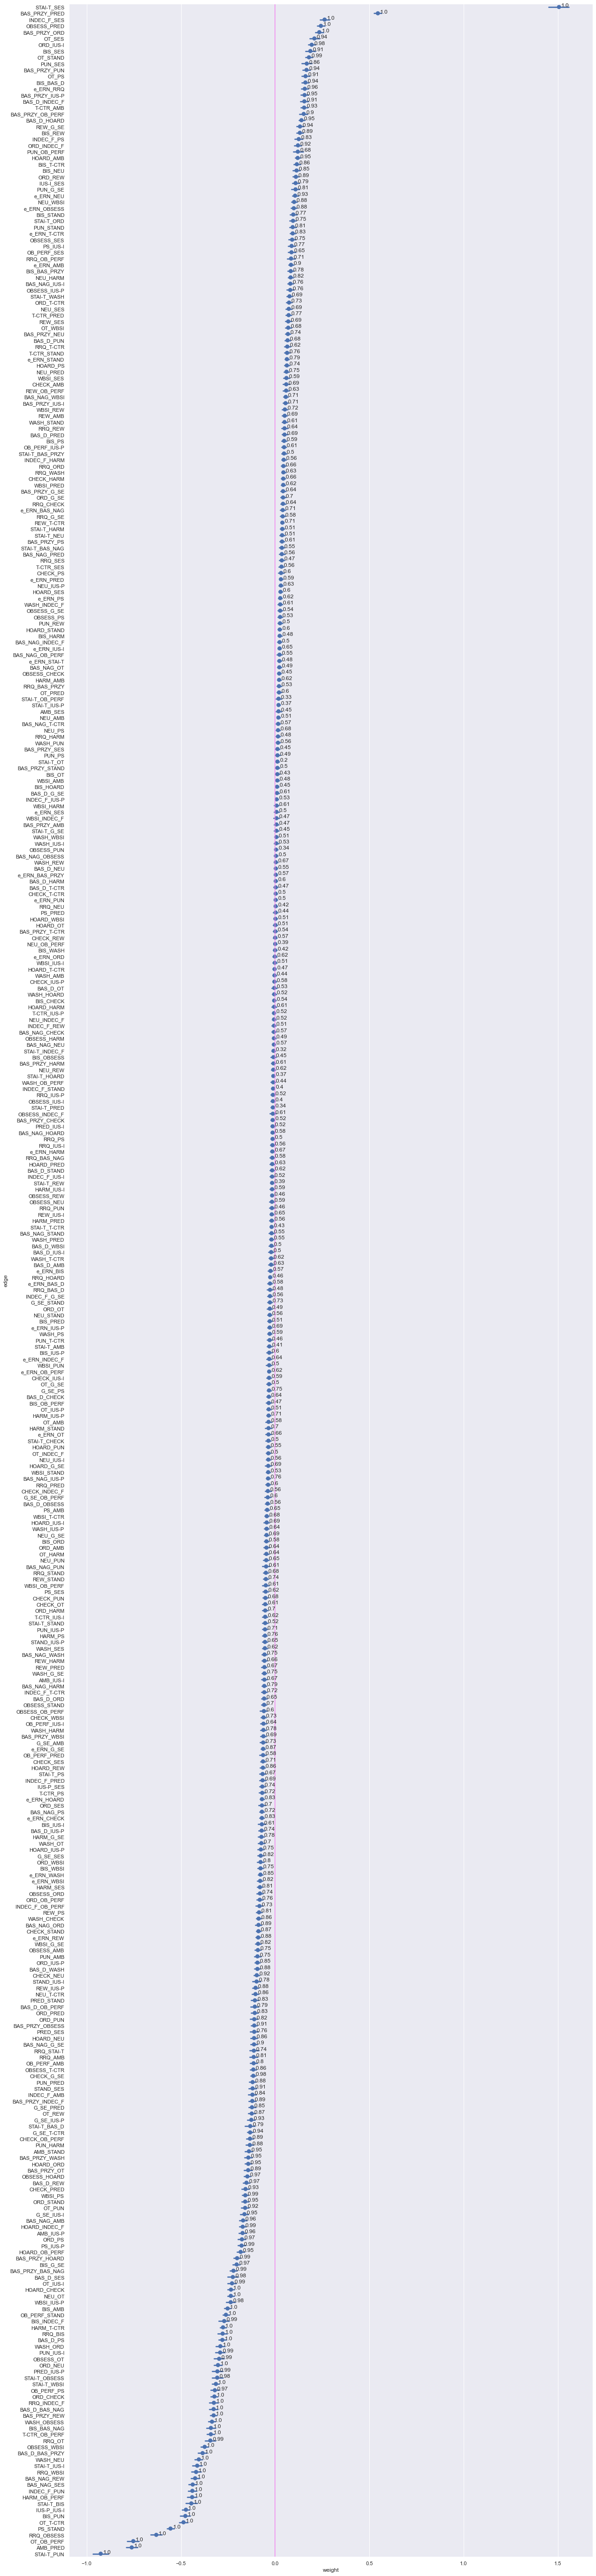

In [122]:
sns.set(rc={'figure.figsize':(20 , 100)})

ax = sns.pointplot(
    x="weight", 
    y="edge", 
    data=bootstraped_links_concatenated_df, 
    orient= 'h',
    join=False,
)

ax.axvline(x=0, color='violet')

mean_df = bootstraped_links_concatenated_df.groupby(['edge'])[['weight', 'non_zero']].mean()
mean_df = mean_df.sort_values(by='weight', ascending=False)

for i, row in enumerate(mean_df.itertuples()):

    x_value, mean, non_zero_mean = row
    
    plt.annotate(
        round(non_zero_mean, 2),               # label text
        (mean, i),                    # (x, y)
        textcoords="offset points",   
        xytext=(5, 0),               # (x, y) offset amount
        ha='left'
    )

### Similarity of network

#### Correlation links similarity

In [203]:
def get_matrix_triu_as_list(matrix, threshold = 0.02):
    
    precision_matrix_df = matrix.where(np.triu(np.ones(matrix.shape)).astype(np.bool))
    precision_matrix_df = precision_matrix_df.mask(abs(precision_matrix_df) <= threshold, 0.0)

    links = precision_matrix_df.stack().reset_index()
    links.columns = ['var1', 'var2','weight']
    links=links.loc[(links['var1'] != links['var2']) ]
    
    return links['weight'].to_numpy()

In [204]:
def pearsonr_links_similarity(matrix1, matrix2):
    links1 = get_matrix_triu_as_list(matrix1)
    links2 = get_matrix_triu_as_list(matrix2)
    
    corr, p_value = pearsonr(links1, links2)
    
    return corr, p_value

In [206]:
for i in range(0, len(precision_matrixes)):
    corr, p_value = pearsonr_links_similarity(precision_matrixes[i], precision_matrixes_test[i])
    print(f"Correlation: {corr} p-value: {p_value}\n")

Correlation: 0.7621049187682444 p-value: 2.779565176838424e-78

Correlation: 0.7522060595353515 p-value: 6.513674005305015e-86

Correlation: 0.7371562730995143 p-value: 3.16435761543025e-97



#### Cosine links similarity

In [221]:
def cosine_links_similarity(matrix1, matrix2):
    links1 = get_matrix_triu_as_list(matrix1).reshape(1, -1)
    links2 = get_matrix_triu_as_list(matrix2).reshape(1, -1)
    
    similarity = cosine_similarity(links1, links2)[0][0]
    
    return similarity

In [222]:
for i in range(0, len(precision_matrixes)):
    similarity = cosine_links_similarity(precision_matrixes[i], precision_matrixes_test[i])
    print(f"Cosine similarity: {similarity}\n")

Cosine similarity: 0.7806913585128975

Cosine similarity: 0.7702338042573316

Cosine similarity: 0.7519358593019443



####  [Levenshtein distance](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.similarity.optimize_graph_edit_distance.html)

In [ ]:
# similarities = []

# if test:
#     for graphs_ in (graphs, test_graphs):
#         G1 = graphs_[0]
#         G2 = graphs_[1]
#         similarity = nx.graph_edit_distance(G1, G2, timeout=10800)
#         similarities.append(similarity)

In [251]:
similarities = []

if test:
    for i in range(0,len(graphs)):
        print(graphs[i])
        print(test_graphs[i])
        G1 = graphs[i]
        G2 = test_graphs[i]
        similarity = nx.optimize_graph_edit_distance(G1, G2)
        similarities.append(similarity)

Graph with 29 nodes and 206 edges
Graph with 29 nodes and 168 edges
Graph with 31 nodes and 225 edges
Graph with 31 nodes and 180 edges
Graph with 34 nodes and 273 edges
Graph with 34 nodes and 214 edges


In [253]:
for v in similarities[0]:
    minv = v
    print(minv)

176.0
170.0
168.0
164.0
160.0
158.0
156.0
154.0
152.0
148.0


KeyboardInterrupt: 

In [213]:
graphs[0]

In [218]:
len(test_graphs[0].edges) + len(test_graphs[0].nodes)

197

In [219]:
len(graphs[0].edges) + len(graphs[0].nodes)

235

In [220]:
235/100

2.35

In [226]:
((235 - 131)/235)

0.4425531914893617

In [227]:
(5 -2)/5

0.6